## Configurações gerais

In [74]:
## coloque os outros códigos antes...

# https://neptune.ai/blog/google-colab-dealing-with-files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
# !pip install pandas
# !pip install numpy
# !pip install matplotlib==3.5.3
# !pip install docxtpl
from docxtpl import DocxTemplate, InlineImage
from docx.shared import Cm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

## Preparação banco de dados

In [76]:
planilha = pd.read_excel("/content/drive/My Drive/CNJ-mortes/df_final_ajust.xlsx")

In [77]:
indexes_para_remover = []
for idx in planilha.index:
  if planilha.iloc[idx]["5 - É caso de interesse?"] != "sim: morte interna" and planilha.iloc[idx]["5 - É caso de interesse?"] != "sim: morte externa":
    indexes_para_remover.append(idx)

planilha_filtrada = planilha.drop(labels=indexes_para_remover)

### Criação variáveis

#### Renda Tratada

In [78]:
import unicodedata
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [79]:
variavel = '29 - Renda (coloque apenas o valor em números. Ex: 1.275,50 ou "SI" para casos sem informação'
arr_renda = []

"""
58 30 reais a diaria
60 800,00 por mes
65 1300,00 por mes
73 50,00 por dia de trabalho
93 60/diaria
95 menos de 1 salario minimo
1258 80,00 (diaria de terca e quinta)
1735 1.500,00; 2.000
1740 120,00/dia
1790 2.500,00; 998,00 (inss)
2070 salario minimo
2400 ate 2 salarios minimos
2454 ate um salario minimo
2584 800 euros
2926 300,00 por dia (comercializar drogas)
"""
planilha_filtrada.at[58, variavel] = 30*30
planilha_filtrada.at[60, variavel] = 800
planilha_filtrada.at[65, variavel] = 1300
planilha_filtrada.at[73, variavel] = 50*30
planilha_filtrada.at[93, variavel] = 60*30
planilha_filtrada.at[95, variavel] = 1045 # morte 2020
planilha_filtrada.at[1258, variavel] = 160*4
planilha_filtrada.at[1735, variavel] = 3500 # [2500, 998] --- devo somar?
planilha_filtrada.at[1740, variavel] = 120*30
planilha_filtrada.at[1790, variavel] = 3498
planilha_filtrada.at[2070, variavel] = 998 # morte 2019
planilha_filtrada.at[2400, variavel] = 2*998	# morte 2019
planilha_filtrada.at[2454, variavel] = 937 # morte 2017
planilha_filtrada.at[2584, variavel] = 800*4.48 # morte 2019/10/24 --- https://br.investing.com/currencies/eur-brl-historical-data
planilha_filtrada.at[2926, variavel] = 300*30

for idx in planilha_filtrada.index:
  line = planilha_filtrada.at[idx, variavel]

  if pd.isnull(line):
    arr_renda.append(0)
    continue
  
  if type(line)==int or type(line)==float:
    arr_renda.append(line)
    continue
  
  line = strip_accents(line).lower().strip()
  if line == "si":
    arr_renda.append(0)
    continue
  
  if line == "nsa":
    arr_renda.append(0)
    continue
  
  # print(idx, line)
# print(arr_renda)
planilha_filtrada['Renda Tratada'] = arr_renda
# for l in planilha_filtrada['Renda Tratada']:
  # print(l)

#### Quantidade de comorbidades

In [107]:
planilha_filtrada["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_filtrada["22 - Situação de saúde com comorbidade (descreva na opção outros)"].astype(str).str.replace(",|\+",";", regex = True)
planilha_filtrada["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_filtrada["22 - Situação de saúde com comorbidade (descreva na opção outros)"].astype(str).str.replace("(?:)\se\s",";", regex = True)
planilha_filtrada["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_filtrada["22 - Situação de saúde com comorbidade (descreva na opção outros)"].astype(str).str.replace("nan","", regex = True)
# pd.set_option('display.max_rows', None)
# print(planilha_filtrada["22 - Situação de saúde com comorbidade (descreva na opção outros)"])

arr_qtd_comorb = []
dict_grupos_comorb = {}
for line in planilha_filtrada["22 - Situação de saúde com comorbidade (descreva na opção outros)"]:
  if pd.isnull(line):
    arr_qtd_comorb.append(None)
    continue

  if ";" not in line:
    doc_sanitizado = strip_accents(line).strip().lower()
    if doc_sanitizado == "":
      arr_qtd_comorb.append(None)
      continue
    if doc_sanitizado == "sem informacao":
      arr_qtd_comorb.append(None)
      if doc_sanitizado not in dict_grupos_comorb.keys():
        dict_grupos_comorb[doc_sanitizado] = 1
      else:
        dict_grupos_comorb[doc_sanitizado] += 1
      continue
    if doc_sanitizado == "nao":
      arr_qtd_comorb.append(0)
      continue
    arr_qtd_comorb.append(1)
    if doc_sanitizado not in dict_grupos_comorb.keys():
      dict_grupos_comorb[doc_sanitizado] = 1
    else:
      dict_grupos_comorb[doc_sanitizado] += 1
  else:
    docs = line.split(";")
    arr_qtd_comorb.append(len(docs))
    for doc in docs:
      doc_sanitizado = doc.strip().lower()
      if doc_sanitizado == "":
        continue
      if doc_sanitizado not in dict_grupos_comorb.keys():
        dict_grupos_comorb[doc_sanitizado] = 1
      else:
        dict_grupos_comorb[doc_sanitizado] += 1


print(len(arr_qtd_comorb))
# print(arr_qtd_comorb)
planilha_filtrada["Quantidade de comorbidades"] = arr_qtd_comorb
print(len(planilha_filtrada["Quantidade de comorbidades"]))
# print(dict_grupos_comorb['sem informacao'])
# print(dict_grupos_comorb)

1168
1168


### Tempo de pena da sentença

In [81]:
import unicodedata
def strip_accents(s):
   return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [82]:
import re


variavel = '35 - Tempo de pena - em caso de condenação (no processo analisado) - por favor coloque no padrão (X anos, y meses e z dias + Multa) e se houver mais de uma, separar por ponto e vírgula ";"'
arr_tempo_pena_sentenca = []

planilha_filtrada.at[46, variavel] = "7 anos, 6 meses +15 dias-multa"
planilha_filtrada.at[830, variavel] = "2 anos +10 dias-multa"
planilha_filtrada.at[1288, variavel] = None
planilha_filtrada.at[1296, variavel] = None
planilha_filtrada.at[2071, variavel] = "26 anos e 8 meses de reclusão + 580 dias-multa"
planilha_filtrada.at[2107, variavel] = "3 anos e 4 meses + 34 dias-multa"
planilha_filtrada.at[2310, variavel] = "1 ano e 9 meses + 190 dias-multa (acódão)."
planilha_filtrada.at[2507, variavel] = "6 anos e 6 meses + multa"
planilha_filtrada.at[2637, variavel] = "3 anos, 6 meses e 5 dias +159 dias-multa"
planilha_filtrada.at[2644, variavel] = "5 anos, 6 meses e 20 dias + 30 dias-multa"
planilha_filtrada.at[2781, variavel] = "15 anos, 10 meses e 29 dias"
planilha_filtrada.at[2925, variavel] = None
planilha_filtrada.at[3001, variavel] = None
planilha_filtrada.at[3005, variavel] = "3 anos, 6 meses e 20 dias + 9 dias-multa"
planilha_filtrada.at[3513, variavel] = None
planilha_filtrada.at[3608, variavel] = "7 anos, 3 meses, 3 dias + 437,00"
planilha_filtrada.at[3610, variavel] = "2 anos, 11 meses, 0 dias + 11 dias-multa"
planilha_filtrada.at[3611, variavel] = "2 anos, 10 dias-multa" 
planilha_filtrada.at[3614, variavel] = "6 meses e 10 dias-multa"
planilha_filtrada.at[3620, variavel] = "1 mês"
planilha_filtrada.at[3633, variavel] = "2 anos"
planilha_filtrada.at[3656, variavel] = "29 anos, 4 meses + 26 dias-multa a 1/30"
planilha_filtrada.at[3671, variavel] = "5 anos + 500 dias-multa"
planilha_filtrada.at[3682, variavel] = "NSA"
planilha_filtrada.at[3696, variavel] = "2 anos, 7 meses e 5 dias + 20 dias-multa no minimo"
planilha_filtrada.at[3717, variavel] = "8 anos, 6 meses + 520 dias-multa"
planilha_filtrada.at[3818, variavel] = "4 anos + 1 ano e 10 meses de detencao + 36 dias-multa"

for idx in planilha_filtrada[variavel].index:
  line = planilha_filtrada.at[idx, variavel]
  if pd.isnull(line):
    arr_tempo_pena_sentenca.append(None)
    continue
  elif str(line).lower() == "si" or str(line).lower() == "nsa":
    arr_tempo_pena_sentenca.append(None)
    continue
  
  line = strip_accents(line.lower())
  # print(idx, line, end=" ")
  ultima_pos = 0
  ano = mes = dia = dia_multa = 0
  if ";" not in line:
    if "ano" in line:
      indices_ano = [i for i in range(len(line)) if line.startswith("ano", i)]
      if len(indices_ano) > 1:
        for indice in indices_ano:
          pos_ano = line.find("ano", indice)
          ano_aux = re.sub('\D', '', line[ultima_pos:pos_ano])
          if ano_aux != '':
            ano = int(ano_aux) if ano == "" else int(ano)+int(ano_aux)
          ultima_pos = pos_ano
          # print(ano, end=" ")
      else:
        pos_ano = line.find("ano")
        ano_aux = re.sub('\D', '', line[ultima_pos:pos_ano])
        if ano_aux != '':
          ano = int(ano_aux) if ano == "" else int(ano)+int(ano_aux)
        ultima_pos = pos_ano
        # print(ano, end=" ")
    
    if "mes" in line:
      indices_mes = [i for i in range(len(line)) if line.startswith("mes", i)]
      if len(indices_mes) > 1:
        for indice in indices_mes:
          pos_mes = line.find("mes", indice)
          mes_aux = re.sub('\D', '', line[ultima_pos:pos_mes])
          if mes_aux != '':
            mes = int(mes_aux) if mes == "" else int(mes)+int(mes_aux)
          ultima_pos = pos_mes
          # print(mes, end=" ")
      else:
        pos_mes = line.find("mes")
        mes_aux = re.sub('\D', '', line[ultima_pos:pos_mes])
        if mes_aux != '':
          mes = int(mes_aux) if mes == "" else int(mes)+int(mes_aux)
        ultima_pos = pos_mes
        # print(mes, end=" ")
      
    if "dia" in line:
      indices_dia = [i for i in range(len(line)) if line.startswith("dia", i)]
      if len(indices_dia) > 1:
        for idx_indice in range(len(indices_dia)):
          pos_atual = indices_dia[idx_indice]
          if idx_indice < len(indices_dia)-1:
            pos_prox = indices_dia[idx_indice]+1
            if "-multa" not in line[pos_atual:pos_prox]:
              pos_dia = line.find("dia", pos_atual)
              dia_aux = re.sub('\D', '', line[ultima_pos:pos_dia])
              if dia_aux != '':
                dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
              ultima_pos = pos_dia
            else:
              pos_dia_multa = line.find("dia", pos_atual)
              dia_multa_aux = re.sub('\D', '', line[ultima_pos:pos_dia_multa])
              if dia_multa_aux != '':
                dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
              ultima_pos = pos_dia_multa
          else:
            if "-multa" not in line:
              pos_dia = line.find("dia", pos_atual)
              dia_aux = re.sub('\D', '', line[ultima_pos:pos_dia])
              if dia_aux != '':
                dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
              ultima_pos = pos_dia
            else:
              pos_dia_multa = line.find("dia", pos_atual)
              dia_multa_aux = re.sub('\D', '', line[ultima_pos:pos_dia_multa])
              if dia_multa_aux != '':
                dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
              ultima_pos = pos_dia_multa
      else:
        if "-multa" not in line:
          pos_dia = line.find("dia")
          dia_aux = re.sub('\D', '', line[ultima_pos:pos_dia])
          if dia_aux != '':
            dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
          ultima_pos = pos_dia
        else:
          pos_dia_multa = line.find("dia")
          dia_multa_aux = re.sub('\D', '', line[ultima_pos:pos_dia_multa])
          if dia_multa_aux != '':
            dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
          ultima_pos = pos_dia_multa

      # print(dia, dia_multa)
    arr_tempo_pena_sentenca.append((ano, mes, dia))
  else:
    arr_aux = []
    line_splited = [p.strip() for p in line.split(";")]
    for line_ in line_splited:
      ultima_pos = 0
      ano = mes = dia = dia_multa = 0
      if "ano" in line_:
        indices_ano = [i for i in range(len(line_)) if line_.startswith("ano", i)]
        if len(indices_ano) > 1:
          for indice in indices_ano:
            pos_ano = line_.find("ano", indice)
            ano_aux = re.sub('\D', '', line_[ultima_pos:pos_ano])
            if ano_aux != '':
              ano = int(ano_aux) if ano == "" else int(ano)+int(ano_aux)
            ultima_pos = pos_ano
            # print(ano, end=" ")
        else:
          pos_ano = line_.find("ano")
          ano_aux = re.sub('\D', '', line_[ultima_pos:pos_ano])
          if ano_aux != '':
            ano = int(ano_aux) if ano == "" else int(ano)+int(ano_aux)
          ultima_pos = pos_ano
          # print(ano, end=" ")
      
      if "mes" in line_:
        indices_mes = [i for i in range(len(line_)) if line_.startswith("mes", i)]
        if len(indices_mes) > 1:
          for indice in indices_mes:
            pos_mes = line_.find("mes", indice)
            mes_aux = re.sub('\D', '', line_[ultima_pos:pos_mes])
            if mes_aux != '':
              mes = int(mes_aux) if mes == "" else int(mes)+int(mes_aux)
            ultima_pos = pos_mes
            # print(mes, end=" ")
        else:
          pos_mes = line_.find("mes")
          mes_aux = re.sub('\D', '', line_[ultima_pos:pos_mes])
          if mes_aux != '':
            mes = int(mes_aux) if mes == "" else int(mes)+int(mes_aux)
          ultima_pos = pos_mes
          # print(mes, end=" ")
        
      if "dia" in line_:
        indices_dia = [i for i in range(len(line_)) if line_.startswith("dia", i)]
        if len(indices_dia) > 1:
          for idx_indice in range(len(indices_dia)):
            pos_atual = indices_dia[idx_indice]
            if idx_indice < len(indices_dia)-1:
              pos_prox = indices_dia[idx_indice]+1
              if "-multa" not in line_[pos_atual:pos_prox]:
                pos_dia = line_.find("dia", pos_atual)
                dia_aux = re.sub('\D', '', line_[ultima_pos:pos_dia])
                if dia_aux != '':
                  dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
                ultima_pos = pos_dia
              else:
                pos_dia_multa = line_.find("dia", pos_atual)
                dia_multa_aux = re.sub('\D', '', line_[ultima_pos:pos_dia_multa])
                if dia_multa_aux != '':
                  dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
                ultima_pos = pos_dia_multa
            else:
              if "-multa" not in line_:
                pos_dia = line_.find("dia", pos_atual)
                dia_aux = re.sub('\D', '', line_[ultima_pos:pos_dia])
                if dia_aux != '':
                  dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
                ultima_pos = pos_dia
              else:
                pos_dia_multa = line_.find("dia", pos_atual)
                dia_multa_aux = re.sub('\D', '', line_[ultima_pos:pos_dia_multa])
                if dia_multa_aux != '':
                  dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
                ultima_pos = pos_dia_multa
        else:
          if "-multa" not in line_:
            pos_dia = line_.find("dia")
            dia_aux = re.sub('\D', '', line_[ultima_pos:pos_dia])
            if dia_aux != '':
              dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
            ultima_pos = pos_dia
          else:
            pos_dia_multa = line_.find("dia")
            dia_multa_aux = re.sub('\D', '', line_[ultima_pos:pos_dia_multa])
            if dia_multa_aux != '':
              dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
            ultima_pos = pos_dia_multa
        # print(dia, dia_multa)
      arr_aux.append((ano, mes, dia))
    arr_tempo_pena_sentenca.append(arr_aux)
  # print(arr_tempo_pena_sentenca[-1])

  # print()
# problemas = [2002, 2241, 2937, 3471, 3566, 3568, 3569, 3572, 3578, 3591, 3640]
# for j in problemas:
  # print(j, planilha_filtrada.at[j, variavel])

arr_tempo_pena_sentenca_dias = []
for arr in arr_tempo_pena_sentenca:
  if arr is None:
    arr_tempo_pena_sentenca_dias.append(None)
    continue

  if type(arr)==tuple:
    anos_p_dias = arr[0]*365
    mes_p_dias = arr[1]*30
    arr_tempo_pena_sentenca_dias.append(anos_p_dias+mes_p_dias+arr[2])
  else:
    arr_aux = []
    for arr_i in arr:
      anos_p_dias = arr_i[0]*365
      mes_p_dias = arr_i[1]*30
      arr_aux.append(anos_p_dias+mes_p_dias+arr_i[2])
    arr_tempo_pena_sentenca_dias.append(np.nansum(arr_aux))
planilha_filtrada["Tempo de pena da sentença (em dias)"] = arr_tempo_pena_sentenca_dias
# print(planilha_filtrada.at[3057,"Tempo de pena da sentença (em dias)"])


### Tempo total de pena

In [83]:
import re


variavel = '36 - Caso haja condenação em outros processos, qual o tempo de condenação total? (se não houver colocar "NSA" para não se aplica ou "SI" se houver outro processo, mas não temos essa informação)'
variavel_aux = 'Tempo de pena da sentença (em dias)'
arr_tempo_total_pena = []

planilha_filtrada[2402, variavel] = None
planilha_filtrada[2753, variavel] = None
planilha_filtrada[3393, variavel] = None

for idx in planilha_filtrada[variavel].index:
  line = planilha_filtrada.at[idx, variavel]
  if pd.isnull(line):
    arr_tempo_total_pena.append(None)
    continue
  elif str(line).lower().strip() == "nsa":
    arr_tempo_total_pena.append(None)
    continue
  elif str(line).lower().strip() == "si":
    if planilha_filtrada.at[idx, variavel_aux] is not None:
      arr_tempo_total_pena.append(planilha_filtrada.at[idx, variavel_aux])
    else:
      arr_tempo_total_pena.append(None)
    continue
  
  line = strip_accents(line.lower())
  # print(idx, line, end=" ")
  ultima_pos = 0
  ano = mes = dia = dia_multa = 0
  if ";" not in line:
    if "ano" in line:
      indices_ano = [i for i in range(len(line)) if line.startswith("ano", i)]
      if len(indices_ano) > 1:
        for indice in indices_ano:
          pos_ano = line.find("ano", indice)
          ano_aux = re.sub('\D', '', line[ultima_pos:pos_ano])
          if ano_aux != '':
            ano = int(ano_aux) if ano == "" else int(ano)+int(ano_aux)
          ultima_pos = pos_ano
          # print(ano, end=" ")
      else:
        pos_ano = line.find("ano")
        ano_aux = re.sub('\D', '', line[ultima_pos:pos_ano])
        if ano_aux != '':
          ano = int(ano_aux) if ano == "" else int(ano)+int(ano_aux)
        ultima_pos = pos_ano
        # print(ano, end=" ")
    
    if "mes" in line:
      indices_mes = [i for i in range(len(line)) if line.startswith("mes", i)]
      if len(indices_mes) > 1:
        for indice in indices_mes:
          pos_mes = line.find("mes", indice)
          mes_aux = re.sub('\D', '', line[ultima_pos:pos_mes])
          if mes_aux != '':
            mes = int(mes_aux) if mes == "" else int(mes)+int(mes_aux)
          ultima_pos = pos_mes
          # print(mes, end=" ")
      else:
        pos_mes = line.find("mes")
        mes_aux = re.sub('\D', '', line[ultima_pos:pos_mes])
        if mes_aux != '':
          mes = int(mes_aux) if mes == "" else int(mes)+int(mes_aux)
        ultima_pos = pos_mes
        # print(mes, end=" ")
      
    if "dia" in line:
      indices_dia = [i for i in range(len(line)) if line.startswith("dia", i)]
      if len(indices_dia) > 1:
        for idx_indice in range(len(indices_dia)):
          pos_atual = indices_dia[idx_indice]
          if idx_indice < len(indices_dia)-1:
            pos_prox = indices_dia[idx_indice]+1
            if "-multa" not in line[pos_atual:pos_prox]:
              pos_dia = line.find("dia", pos_atual)
              dia_aux = re.sub('\D', '', line[ultima_pos:pos_dia])
              if dia_aux != '':
                dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
              ultima_pos = pos_dia
            else:
              pos_dia_multa = line.find("dia", pos_atual)
              dia_multa_aux = re.sub('\D', '', line[ultima_pos:pos_dia_multa])
              if dia_multa_aux != '':
                dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
              ultima_pos = pos_dia_multa
          else:
            if "-multa" not in line:
              pos_dia = line.find("dia", pos_atual)
              dia_aux = re.sub('\D', '', line[ultima_pos:pos_dia])
              if dia_aux != '':
                dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
              ultima_pos = pos_dia
            else:
              pos_dia_multa = line.find("dia", pos_atual)
              dia_multa_aux = re.sub('\D', '', line[ultima_pos:pos_dia_multa])
              if dia_multa_aux != '':
                dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
              ultima_pos = pos_dia_multa
      else:
        if "-multa" not in line:
          pos_dia = line.find("dia")
          dia_aux = re.sub('\D', '', line[ultima_pos:pos_dia])
          if dia_aux != '':
            dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
          ultima_pos = pos_dia
        else:
          pos_dia_multa = line.find("dia")
          dia_multa_aux = re.sub('\D', '', line[ultima_pos:pos_dia_multa])
          if dia_multa_aux != '':
            dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
          ultima_pos = pos_dia_multa

      # print(dia, dia_multa)
    arr_tempo_total_pena.append((ano, mes, dia))
  else:
    arr_aux = []
    line_splited = [p.strip() for p in line.split(";")]
    for line_ in line_splited:
      ultima_pos = 0
      ano = mes = dia = dia_multa = 0
      if "ano" in line_:
        indices_ano = [i for i in range(len(line_)) if line_.startswith("ano", i)]
        if len(indices_ano) > 1:
          for indice in indices_ano:
            pos_ano = line_.find("ano", indice)
            ano_aux = re.sub('\D', '', line_[ultima_pos:pos_ano])
            if ano_aux != '':
              ano = int(ano_aux) if ano == "" else int(ano)+int(ano_aux)
            ultima_pos = pos_ano
            # print(ano, end=" ")
        else:
          pos_ano = line_.find("ano")
          ano_aux = re.sub('\D', '', line_[ultima_pos:pos_ano])
          if ano_aux != '':
            ano = int(ano_aux) if ano == "" else int(ano)+int(ano_aux)
          ultima_pos = pos_ano
          # print(ano, end=" ")
      
      if "mes" in line_:
        indices_mes = [i for i in range(len(line_)) if line_.startswith("mes", i)]
        if len(indices_mes) > 1:
          for indice in indices_mes:
            pos_mes = line_.find("mes", indice)
            mes_aux = re.sub('\D', '', line_[ultima_pos:pos_mes])
            if mes_aux != '':
              mes = int(mes_aux) if mes == "" else int(mes)+int(mes_aux)
            ultima_pos = pos_mes
            # print(mes, end=" ")
        else:
          pos_mes = line_.find("mes")
          mes_aux = re.sub('\D', '', line_[ultima_pos:pos_mes])
          if mes_aux != '':
            mes = int(mes_aux) if mes == "" else int(mes)+int(mes_aux)
          ultima_pos = pos_mes
          # print(mes, end=" ")
        
      if "dia" in line_:
        indices_dia = [i for i in range(len(line_)) if line_.startswith("dia", i)]
        if len(indices_dia) > 1:
          for idx_indice in range(len(indices_dia)):
            pos_atual = indices_dia[idx_indice]
            if idx_indice < len(indices_dia)-1:
              pos_prox = indices_dia[idx_indice]+1
              if "-multa" not in line_[pos_atual:pos_prox]:
                pos_dia = line_.find("dia", pos_atual)
                dia_aux = re.sub('\D', '', line_[ultima_pos:pos_dia])
                if dia_aux != '':
                  dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
                ultima_pos = pos_dia
              else:
                pos_dia_multa = line_.find("dia", pos_atual)
                dia_multa_aux = re.sub('\D', '', line_[ultima_pos:pos_dia_multa])
                if dia_multa_aux != '':
                  dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
                ultima_pos = pos_dia_multa
            else:
              if "-multa" not in line_:
                pos_dia = line_.find("dia", pos_atual)
                dia_aux = re.sub('\D', '', line_[ultima_pos:pos_dia])
                if dia_aux != '':
                  dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
                ultima_pos = pos_dia
              else:
                pos_dia_multa = line_.find("dia", pos_atual)
                dia_multa_aux = re.sub('\D', '', line_[ultima_pos:pos_dia_multa])
                if dia_multa_aux != '':
                  dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
                ultima_pos = pos_dia_multa
        else:
          if "-multa" not in line_:
            pos_dia = line_.find("dia")
            dia_aux = re.sub('\D', '', line_[ultima_pos:pos_dia])
            if dia_aux != '':
              dia = int(dia_aux) if dia == "" else int(dia)+int(dia_aux)
            ultima_pos = pos_dia
          else:
            pos_dia_multa = line_.find("dia")
            dia_multa_aux = re.sub('\D', '', line_[ultima_pos:pos_dia_multa])
            if dia_multa_aux != '':
              dia_multa = int(dia_multa_aux) if dia_multa == "" else int(dia_multa)+int(dia_multa_aux)
            ultima_pos = pos_dia_multa
        # print(dia, dia_multa)
      arr_aux.append((ano, mes, dia))
    arr_tempo_total_pena.append(arr_aux)
  # print(arr_tempo_total_pena[-1])

  # print()
# problemas = [2002, 2241, 2937, 3471, 3566, 3568, 3569, 3572, 3578, 3591, 3640]
# for j in problemas:
  # print(j, planilha_filtrada.at[j, variavel])

# print(arr_tempo_total_pena)
arr_tempo_total_pena_dias = []
for arr in arr_tempo_total_pena:
  if arr is None:
    arr_tempo_total_pena_dias.append(None)
    continue

  if type(arr)==int or type(arr)==np.float64:
    arr_tempo_total_pena_dias.append(arr)
  elif type(arr)==tuple:
    anos_p_dias = arr[0]*365
    mes_p_dias = arr[1]*30
    arr_tempo_total_pena_dias.append(anos_p_dias+mes_p_dias+arr[2])
  else:
    arr_aux = []
    for arr_i in arr:
      anos_p_dias = arr_i[0]*365
      mes_p_dias = arr_i[1]*30
      arr_aux.append(anos_p_dias+mes_p_dias+arr_i[2])
    arr_tempo_total_pena_dias.append(np.nansum(arr_aux))
planilha_filtrada["Tempo total de pena"] = arr_tempo_total_pena_dias
# print(planilha_filtrada.at[3057,"Tempo de pena da sentença (em dias)"])


### Filtra planilhas

In [84]:
# print(len(planilha_filtrada))

planilha_filtrada_interna = planilha_filtrada[planilha_filtrada["5 - É caso de interesse?"] == "sim: morte interna"]
# print(len(planilha_filtrada_interna))
planilha_filtrada_externa = planilha_filtrada[planilha_filtrada["5 - É caso de interesse?"] == "sim: morte externa"]
# print(len(planilha_filtrada_externa))

## Funções de uso geral

In [85]:
def combine(counts, percentages):
    fmt = ' {:.2f}% ({})'.format
    return [fmt(p, c) for c, p in zip(counts, percentages)]

In [86]:
def gera_grafico_geral(variavel, planilha_filtrada, titulo="Media e Medianas Gerais", cor="#ba2e2e", eixo_y=(200, 1400, 200), fonttamanho=17, fonttitulo=20, fontlabel=15, x=22, y=10):
  # print(f'Número total de registros vazios: {planilha_filtrada[variavel].isna().sum()}')

  plt.style.use(['ggplot'])
  fig, ax = plt.subplots(figsize=(x,y))
  fig.suptitle(titulo, fontsize=fonttitulo)

  geral_absolute = planilha_filtrada[variavel].value_counts()
  geral_relative = planilha_filtrada[variavel].value_counts(normalize=True)*100
  if geral_relative.size != 0:
    # ax.xticks(range(eixo_y[0], eixo_y[1], eixo_y[2]))
    geral_relative_plt = geral_relative.plot(ax=ax, kind='barh', color=[cor], fontsize=fonttamanho, edgecolor="black")
    ax.bar_label(ax.containers[0], labels=combine(geral_absolute, geral_relative), fontsize=fontlabel)
    plt.xticks(range(eixo_y[0], eixo_y[1], eixo_y[2]))

  return (plt, fig)

def gera_grafico_geral_media(variavel, planilha_filtrada, titulo="Media e Medianas Gerais", cor="#ba2e2e", eixo_y=(200, 1400, 200), fonttamanho=12):
  # Geral
  media_geral = planilha_filtrada[variavel].mean()
  print(f'Média geral de dias: {media_geral}')

  mediana_geral = planilha_filtrada[variavel].median()
  print(f'Mediana geral de dias: {mediana_geral}')

  dict_infos_gerais = {"Média": float("{:.2f}".format(media_geral)), "Mediana": float("{:.2f}".format(mediana_geral))}
  # print(dict_infos_gerais)

  series_dict_infos_geral = pd.Series(dict_infos_gerais)

  plt.style.use(['ggplot'])
  plt.yticks(range(eixo_y[0], eixo_y[1], eixo_y[2]))
  fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(8,8))
  ax.set_title(titulo)
  series_dict_infos_geral.plot(ax=ax, kind='barh', color=[cor], fontsize=fonttamanho, edgecolor="black")
  ax.bar_label(ax.containers[0])

  return (plt, fig)

## Parte 1

### 5 - É caso de interesse?

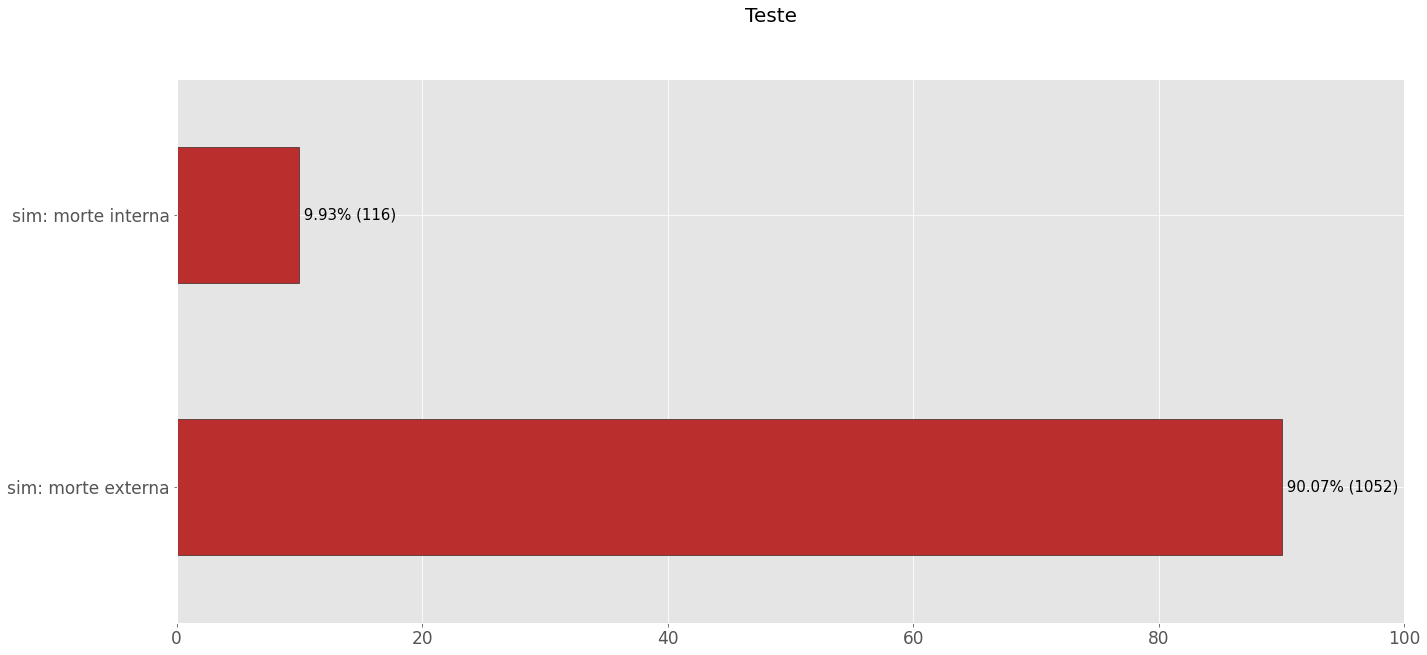

In [71]:
plot, fig = gera_grafico_geral("5 - É caso de interesse?", planilha_filtrada, titulo="Teste", eixo_y=(0, 120, 20))
plot.show()

# loc_geral_variavel_5 = "/content/drive/My Drive/codigos_colab/imagens_graficos_final/1/grafico_geral_variavel_caso_interesse.png"
# fig.savefig(loc_geral_variavel_5)

## Parte 2


### 15 - CPF (apenas números quando houver. Quando não houver colocar "SI")

In [ ]:
sem_preenchimento = 0
dict_infos = {'geral': []}
for line in planilha_filtrada_interna['15 - CPF (apenas números quando houver. Quando não houver colocar "SI")']:
  if str(line).lower() == "si": dict_infos['geral'].append('sem informação')
  elif str(line).lower() == "nan": sem_preenchimento += 1
  else: dict_infos['geral'].append('com informação')

series_arr_valores1 = pd.Series(dict_infos['geral'])
absolute_plt = series_arr_valores1.value_counts()
relative_plt = series_arr_valores1.value_counts(normalize=True)*100


fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle("Morte Interna", fontsize=20)
relative_plot = relative_plt.plot(ax=ax, kind='barh', color=['#ba2e2e'], fontsize=17, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(absolute_plt, relative_plt), fontsize=16)
plt.xticks(range(0, 120, 20))

# loc_geral_variavel_15_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_informacoes_cpf_caso_interno.png"
# fig.savefig(loc_geral_variavel_15_1)

In [ ]:
sem_preenchimento = 0
dict_infos = {'geral': []}
for line in planilha_filtrada_externa['15 - CPF (apenas números quando houver. Quando não houver colocar "SI")']:
  if str(line).lower() == "si": dict_infos['geral'].append('sem informação')
  elif str(line).lower() == "nan": sem_preenchimento += 1
  else: dict_infos['geral'].append('com informação')

series_arr_valores1 = pd.Series(dict_infos['geral'])
absolute_plt = series_arr_valores1.value_counts()
relative_plt = series_arr_valores1.value_counts(normalize=True)*100


fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle("Morte Externa", fontsize=20)
relative_plot = relative_plt.plot(ax=ax, kind='barh', color=['#121fa1'], fontsize=17, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(absolute_plt, relative_plt), fontsize=16)
plt.xticks(range(0, 120, 20))

loc_geral_variavel_15_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_informacoes_cpf_caso_externo.png"
fig.savefig(loc_geral_variavel_15_2)

### 27 - Filhos (quantidade)

In [ ]:
var_27_aux_interna = planilha_filtrada_interna["27 - Filhos (quantidade)"].value_counts().to_frame()
var_27_aux_interna.rename(columns = {"27 - Filhos (quantidade)": "quantidade"}, inplace = True)
var_27_aux_interna = var_27_aux_interna.reset_index()
var_27_aux_interna = var_27_aux_interna.reindex([2,3,4,6,5,1,0])
var_27_aux_interna.set_index('index', inplace=True)

var_27_aux_interna['porcentagem'] = var_27_aux_interna['quantidade']/var_27_aux_interna['quantidade'].sum()*100

plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(18,6))
fig.suptitle("Morte Interna", fontsize=24)
var_27_aux_interna['porcentagem'].plot(ax=ax, kind='barh', color=['#ba2e2e'], fontsize=18, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(var_27_aux_interna['quantidade'], var_27_aux_interna['porcentagem']), fontsize=17)
plt.ylabel(None)
plt.xticks(range(0, 50, 10))


loc_geral_variavel_27_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_quantidade_filhos_caso_interna.png"
fig.savefig(loc_geral_variavel_27_1)

In [ ]:
var_27_aux_externa = planilha_filtrada_externa["27 - Filhos (quantidade)"].value_counts().to_frame()
var_27_aux_externa.rename(columns = {"27 - Filhos (quantidade)": "quantidade"}, inplace = True)
var_27_aux_externa = var_27_aux_externa.reset_index()
var_27_aux_externa = var_27_aux_externa.reindex([2,3,4,5,6,0,1])
var_27_aux_externa.set_index('index', inplace=True)

var_27_aux_externa['porcentagem'] = var_27_aux_externa['quantidade']/var_27_aux_externa['quantidade'].sum()*100

plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(18,6))
fig.suptitle("Morte Externa", fontsize=24)
var_27_aux_externa['porcentagem'].plot(ax=ax, kind='barh', color=['#121fa1'], fontsize=18, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(var_27_aux_externa['quantidade'], var_27_aux_externa['porcentagem']), fontsize=17)
plt.ylabel(None)
plt.xticks(range(0, 50, 10))

loc_geral_variavel_27_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_quantidade_filhos_caso_externa.png"
fig.savefig(loc_geral_variavel_27_2)

In [ ]:
### fazer o com e sem informação dessa variável aqui

# print(planilha_filtrada_interna["27 - Filhos (quantidade)"])

planilha_aux_interna = pd.DataFrame()
planilha_aux_interna["var 27 vazio"] = planilha_filtrada_interna["27 - Filhos (quantidade)"].dropna()
planilha_aux_interna["var 27 vazio"] = np.where(planilha_aux_interna["var 27 vazio"] != "sem informações", "com informação", "sem informação")
print(planilha_aux_interna["var 27 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 27 vazio", planilha_aux_interna, "Quantidade de Dados Faltantes - Filhos (qtd.) - Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))

## interno
loc_geral_variavel_27_vazio_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_filhos_vazio_interna.png"
fig.savefig(loc_geral_variavel_27_vazio_1)

In [ ]:
planilha_aux_externa = pd.DataFrame()
planilha_aux_externa["var 27 vazio"] = planilha_filtrada_externa["27 - Filhos (quantidade)"].dropna()
planilha_aux_externa["var 27 vazio"] = np.where(planilha_aux_externa["var 27 vazio"] != "sem informações", "com informação", "sem informação")
print(planilha_aux_externa["var 27 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 27 vazio", planilha_aux_externa, "Quantidade de Dados Faltantes - Filhos (qtd.) - Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

# externo
loc_geral_variavel_27_vazio_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_filhos_vazio_externa.png"
fig.savefig(loc_geral_variavel_27_vazio_2)

### Renda

In [ ]:
import numpy as np

# print(arr_renda_calc)
variavel = '29 - Renda (coloque apenas o valor em números. Ex: 1.275,50 ou "SI" para casos sem informação'
arr_renda_calc = []

qtd_sem_info_interna = 0
qtd_nsa_interna = 0
qtd_linha_vazias_interna = 0

for idx in planilha_filtrada_interna.index:
  line = planilha_filtrada_interna.at[idx, variavel]

  if pd.isnull(line):
    qtd_linha_vazias_interna += 1
    continue
  
  if type(line)==int or type(line)==float:
    # arr_renda.append(line)
    arr_renda_calc.append(line)
    continue
  
  line = strip_accents(line).lower().strip()
  if line == "si":
    qtd_sem_info_interna += 1
    continue
  
  if line == "nsa":
    qtd_nsa_interna += 1
    continue

print("Quantidade de ocorrências sem informação - interna:", qtd_sem_info_interna+qtd_nsa_interna)
# print("Quantidade de NSA - interna:", qtd_nsa_interna)
print("Quantidade de linhas vazias - interna:", qtd_linha_vazias_interna)

mediana_renda_tratada_2 = np.median(arr_renda_calc)
print("Mediana - interna:", mediana_renda_tratada_2)

media_renda_tratada_2 = np.mean(arr_renda_calc)
print("Média - interna:", media_renda_tratada_2)

# print("Valor máximo:", max(arr_renda_calc))


dict_infos_gerais = {"Média": float("{:.2f}".format(media_renda_tratada_2)), "Mediana": float("{:.2f}".format(mediana_renda_tratada_2))}
# print(dict_infos_gerais)

series_dict_infos_geral = pd.Series(dict_infos_gerais)

plt.style.use(['ggplot'])
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(14,6))
ax.set_title("Média e Mediana de Renda (R$) - Morte Interna", fontsize=20)
series_dict_infos_geral.plot(ax=ax, kind='barh', color=["#ba2e2e"], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=[' {:.2f}'.format(media_renda_tratada_2), ' {:.2f}'.format(mediana_renda_tratada_2)], fontsize=13)
plt.xticks(range(0, 2000, 200))

loc_geral_variavel_renda_interna_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_renda_interna_2.png"
fig.savefig(loc_geral_variavel_renda_interna_2)

In [ ]:
### parte nova

dict_aux = {"com informação": [len(arr_renda_calc)], "sem informação": [int(qtd_sem_info_interna+qtd_nsa_interna)]}

pd_sem_info_inter = pd.DataFrame.from_dict(dict_aux)
pd_sem_info_inter.rename(index={0: 'quantidade'}, inplace=True)
pd_sem_info_inter_aux = pd_sem_info_inter.T
# print(pd_sem_info_inter_aux)

pd_sem_info_inter_aux['porcentagem'] = pd_sem_info_inter_aux['quantidade']/pd_sem_info_inter_aux['quantidade'].sum()*100

plt.style.use(['ggplot'])
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(16,8))
ax.set_title("Quantidade de Informações Faltantes - Renda - Morte Interna", fontsize=20)
pd_sem_info_inter_aux['porcentagem'].plot(ax=ax, kind='barh', color=["#ba2e2e"], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(pd_sem_info_inter_aux['quantidade'], pd_sem_info_inter_aux['porcentagem']), fontsize=14)
plt.xticks(range(0, 110, 10))

loc_geral_variavel_renda_interna_sem_info = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_renda_interna_sem_info.png"
fig.savefig(loc_geral_variavel_renda_interna_sem_info)

In [ ]:
df_renda_morte_interna = pd.DataFrame(arr_renda_calc, columns=['Renda - Morte Interna'])
# print(df_renda_morte_interna)
faixas = ["0 a 500", "500 a 1000", "1000 a 1500", "1500 a 2000", "2000 a 2500", "2500 a 3000"]
df_renda_morte_interna["Faixas Renda - Morte Interna"] = pd.cut(x=df_renda_morte_interna['Renda - Morte Interna'], bins=[-1,500,1000,1500,2000,2500,3000], labels=faixas)
# print(df_renda_morte_interna["Faixas Renda - Morte Interna"].value_counts())


var_27_aux_faixas_renda_interna = df_renda_morte_interna["Faixas Renda - Morte Interna"].value_counts().to_frame()
var_27_aux_faixas_renda_interna.rename(columns = {"Faixas Renda - Morte Interna": "quantidade"}, inplace = True)
var_27_aux_faixas_renda_interna = var_27_aux_faixas_renda_interna.reset_index()
print(var_27_aux_faixas_renda_interna.index)
var_27_aux_faixas_renda_interna = var_27_aux_faixas_renda_interna.reindex([1,2,0,4,3,5])
var_27_aux_faixas_renda_interna.set_index('index', inplace=True)
# print(var_27_aux_faixas_renda_interna)

# value_counts_renda_morte_interna = var_27_aux_faixas_renda_interna["Faixas Renda - Morte Interna"].value_counts()
labels_value_counts_renda_morte_interna = [' {}'.format(i[0]) for i in var_27_aux_faixas_renda_interna.values]
# print(labels_value_counts_renda_morte_interna)

plt.style.use(['ggplot'])
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(14,6))
ax.set_title("Faixas de Renda (R$) - Morte Interna", fontsize=20)
var_27_aux_faixas_renda_interna['quantidade'].plot(ax=ax, kind='barh', color=["#ba2e2e"], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=labels_value_counts_renda_morte_interna, fontsize=13)
plt.xticks(range(0, max(var_27_aux_faixas_renda_interna['quantidade'].values)+1, 1))
plt.ylabel(None)

loc_geral_variavel_renda_faixa_interna_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_renda_faixa_interna_2.png"
fig.savefig(loc_geral_variavel_renda_faixa_interna_2)

In [ ]:
arr_renda_calc = []
variavel = '29 - Renda (coloque apenas o valor em números. Ex: 1.275,50 ou "SI" para casos sem informação'
qtd_sem_info_externa = 0
qtd_nsa_externa = 0
qtd_linha_vazias_externa = 0

for idx in planilha_filtrada_externa.index:
  line = planilha_filtrada_externa.at[idx, variavel]

  if pd.isnull(line):
    qtd_linha_vazias_externa += 1
    continue
  
  if type(line)==int or type(line)==float:
    # arr_renda.append(line)
    arr_renda_calc.append(line)
    continue
  
  line = strip_accents(line).lower().strip()
  if line == "si":
    qtd_sem_info_externa += 1
    continue
  
  if line == "nsa":
    qtd_nsa_externa += 1
    continue

print("Quantidade de ocorrências sem informação - externa:", qtd_sem_info_externa+qtd_nsa_externa)
# print("Quantidade de NSA - externa:", qtd_nsa_externa)
print("Quantidade de linhas vazias - externa:", qtd_linha_vazias_externa)

mediana_renda_tratada_2 = np.median(arr_renda_calc)
print("Mediana - externa:", mediana_renda_tratada_2)

media_renda_tratada_2 = np.mean(arr_renda_calc)
print("Média - externa:", media_renda_tratada_2)

print("Valor máximo:", max(arr_renda_calc))

dict_infos_gerais = {"Média": float("{:.2f}".format(media_renda_tratada_2)), "Mediana": float("{:.2f}".format(mediana_renda_tratada_2))}
# print(dict_infos_gerais)

series_dict_infos_geral = pd.Series(dict_infos_gerais)

plt.style.use(['ggplot'])
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(14,6))
ax.set_title("Média e Mediana de Renda (R$) - Morte externa", fontsize=20)
series_dict_infos_geral.plot(ax=ax, kind='barh', color=["#121fa1"], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=[' {:.2f}'.format(media_renda_tratada_2), ' {:.2f}'.format(mediana_renda_tratada_2)], fontsize=13)
plt.xticks(range(0, 2000, 200))

loc_geral_variavel_renda_externa_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_renda_externa_2.png"
fig.savefig(loc_geral_variavel_renda_externa_2)

In [ ]:
### parte nova

dict_aux = {"com informação": [len(arr_renda_calc)], "sem informação": [int(qtd_sem_info_externa+qtd_nsa_externa)]}

pd_sem_info_extern = pd.DataFrame.from_dict(dict_aux)
pd_sem_info_extern.rename(index = {0: 'quantidade'}, inplace=True)
pd_sem_info_extern_aux = pd_sem_info_extern.T
pd_sem_info_extern_aux['porcentagem'] = pd_sem_info_extern_aux['quantidade']/pd_sem_info_extern_aux['quantidade'].sum()*100

plt.style.use(['ggplot'])
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(17,8))
ax.set_title("Quantidade de Informações Faltantes - Renda - Morte Externa", fontsize=20)
pd_sem_info_extern_aux['porcentagem'].plot(ax=ax, kind='barh', color=["#121fa1"], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(pd_sem_info_extern_aux['quantidade'], pd_sem_info_extern_aux['porcentagem']), fontsize=14)
# ax.get_legend().remove()
plt.xticks(range(0, 110, 10))

loc_geral_variavel_renda_externa_sem_info = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_renda_externa_sem_info.png"
fig.savefig(loc_geral_variavel_renda_externa_sem_info)

In [ ]:
df_renda_morte_externa = pd.DataFrame(arr_renda_calc, columns=['Renda - Morte Externa'])
# print(df_renda_morte_externa)
faixas = ["0 a 500", "500 a 1000", "1000 a 1500", "1500 a 2000", "2000 a 2500", "2500 a 3000", "3000 a 3500", "Acima de 3500"]
df_renda_morte_externa["Faixas Renda - Morte Externa"] = pd.cut(x=df_renda_morte_externa['Renda - Morte Externa'], bins=[-1,500,1000,1500,2000,2500,3000,3500,20000], labels=faixas)
# print(df_renda_morte_externa["Faixas Renda - Morte Externa"].value_counts())

var_27_aux_faixas_renda_externa = df_renda_morte_externa["Faixas Renda - Morte Externa"].value_counts().to_frame()
# print(var_27_aux_faixas_renda_externa)
var_27_aux_faixas_renda_externa.rename(columns = {"Faixas Renda - Morte Externa": "quantidade"}, inplace = True)
var_27_aux_faixas_renda_externa = var_27_aux_faixas_renda_externa.reset_index()
# print(var_27_aux_faixas_renda_externa)
var_27_aux_faixas_renda_externa = var_27_aux_faixas_renda_externa.reindex([2,0,1,3,4,6,7,5])
var_27_aux_faixas_renda_externa.set_index('index', inplace=True)
# print(var_27_aux_faixas_renda_externa)

# labels_value_counts_renda_morte_externa = var_27_aux_faixas_renda_externa["Faixas Renda - Morte Externa"].value_counts()
labels_value_counts_renda_morte_externa = [' {}'.format(i[0]) for i in var_27_aux_faixas_renda_externa.values]
# print(labels_value_counts_renda_morte_externa)

plt.style.use(['ggplot'])
fig, ax = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(14,6))
ax.set_title("Faixas de Renda (R$) - Morte Externa", fontsize=20)
var_27_aux_faixas_renda_externa['quantidade'].plot(ax=ax, kind='barh', color=["#121fa1"], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=labels_value_counts_renda_morte_externa, fontsize=13)
plt.xticks(range(0, max(var_27_aux_faixas_renda_externa['quantidade'].values)+1, 2))
plt.ylabel(None)

loc_geral_variavel_renda_faixa_externa_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_renda_faixa_externa_2.png"
fig.savefig(loc_geral_variavel_renda_faixa_externa_2)

### 30 - Passagens anteriores pelo sistema de justiça criminal?

In [ ]:
plot, fig = gera_grafico_geral("30 - Passagens anteriores pelo sistema de justiça criminal?", planilha_filtrada_interna, "Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_30_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_passagem_anteriores_criminal_caso_interna.png"
fig.savefig(loc_geral_variavel_30_1)

In [ ]:
planilha_aux_interna = pd.DataFrame()
planilha_aux_interna["var 30 vazio"] = planilha_filtrada_interna["30 - Passagens anteriores pelo sistema de justiça criminal?"].dropna()
planilha_aux_interna["var 30 vazio"] = np.where(planilha_aux_interna["var 30 vazio"] != "sem informação", "com informação", "sem informação")
print(planilha_aux_interna["var 30 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 30 vazio", planilha_aux_interna, "Dados Faltantes - Passagens anteriores pelo sistema de justiça criminal - Morte Interna",
                               x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_30_vazio_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_passagem_anteriores_criminal_vazio_caso_interna.png"
fig.savefig(loc_geral_variavel_30_vazio_1)

In [ ]:
plot, fig = gera_grafico_geral("30 - Passagens anteriores pelo sistema de justiça criminal?", planilha_filtrada_externa, "Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_30_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_passagem_antereiores_criminal_caso_externa.png"
fig.savefig(loc_geral_variavel_30_2)

In [ ]:
planilha_aux_externa = pd.DataFrame()
planilha_aux_externa["var 30 vazio"] = planilha_filtrada_externa["30 - Passagens anteriores pelo sistema de justiça criminal?"].dropna()
planilha_aux_externa["var 30 vazio"] = np.where(planilha_aux_externa["var 30 vazio"] != "sem informação", "com informação", "sem informação")
print(planilha_aux_externa["var 30 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 30 vazio", planilha_aux_externa, "Dados Faltantes - Passagens anteriores pelo sistema de justiça criminal - Morte Externa",
                               cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_30_vazio_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_passagem_anteriores_criminal_vazio_caso_externa.png"
fig.savefig(loc_geral_variavel_30_vazio_2)

### 31 - Há passagens anteriores pelo sistema de justiça socioeducativo?

In [ ]:
plot, fig = gera_grafico_geral("31 - Há passagens anteriores pelo sistema de justiça socioeducativo?", planilha_filtrada_interna, "Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_31_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_passagem_anteriores_socioeducativo_caso_interno.png"
fig.savefig(loc_geral_variavel_31_1)

In [ ]:
plot, fig = gera_grafico_geral("31 - Há passagens anteriores pelo sistema de justiça socioeducativo?", planilha_filtrada_externa, "Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_31_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_passagem_anteriores_socioeducativo_caso_externo.png"
fig.savefig(loc_geral_variavel_31_2)

In [ ]:
### fazer o com e sem informação dessa variável aqui


planilha_aux_interna = pd.DataFrame()
planilha_aux_interna["var 31 vazio"] = planilha_filtrada_interna["31 - Há passagens anteriores pelo sistema de justiça socioeducativo?"].dropna()
planilha_aux_interna["var 31 vazio"] = np.where(planilha_aux_interna["var 31 vazio"] != "sem informação", "com informação", "sem informação")
print(planilha_aux_interna["var 31 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 31 vazio", planilha_aux_interna, "Dados Faltantes - Passagens anteriores pelo sistema de justiça socioeducativo - Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))

## interno
loc_geral_variavel_31_vazio_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_passagem_anteriores_socioeducativo_vazio_caso_interna.png"
fig.savefig(loc_geral_variavel_31_vazio_1)

In [ ]:
planilha_aux_externa = pd.DataFrame()
planilha_aux_externa["var 31 vazio"] = planilha_filtrada_externa["31 - Há passagens anteriores pelo sistema de justiça socioeducativo?"].dropna()
planilha_aux_externa["var 31 vazio"] = np.where(planilha_aux_externa["var 31 vazio"] != "sem informação", "com informação", "sem informação")
print(planilha_aux_externa["var 31 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 31 vazio", planilha_aux_externa, "Dados Faltantes - Passagens anteriores pelo sistema de justiça socioeducativo - Morte Externa",
                               cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

# externo
loc_geral_variavel_31_vazio_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_passagem_anteriores_socioeducativo_vazio_caso_externa.png"
fig.savefig(loc_geral_variavel_31_vazio_2)

### 48 - Há certidão de óbito (sim/não)? 

In [ ]:
plot, fig = gera_grafico_geral("48 - Há certidão de óbito (sim/não)? ", planilha_filtrada_interna, "Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_48_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_existe_certidao_obito_caso_interno.png"
fig.savefig(loc_geral_variavel_48_1)

In [ ]:
plot, fig = gera_grafico_geral("48 - Há certidão de óbito (sim/não)? ", planilha_filtrada_externa, "Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_48_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_existe_certidao_obito_caso_externo.png"
fig.savefig(loc_geral_variavel_48_2)

### 61 - Houve investigação da morte?

In [ ]:
plot, fig = gera_grafico_geral("61 - Houve investigação da morte?", planilha_filtrada_interna, "Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_61_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_houve_investigacao_morte_caso_interno.png"
fig.savefig(loc_geral_variavel_61_1)

In [ ]:
plot, fig = gera_grafico_geral("61 - Houve investigação da morte?", planilha_filtrada_externa, "Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_61_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_houve_investigacao_morte_caso_externo.png"
fig.savefig(loc_geral_variavel_61_2)

In [ ]:
### fazer o com e sem informação dessa variável aqui

planilha_aux_interna = pd.DataFrame()
planilha_aux_interna["var 61 vazio"] = planilha_filtrada_interna["61 - Houve investigação da morte?"].dropna()
planilha_aux_interna["var 61 vazio"] = np.where(planilha_aux_interna["var 61 vazio"] != "sem informação", "com informação", "sem informação")
print(planilha_aux_interna["var 61 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 61 vazio", planilha_aux_interna, "Dados Faltantes - Houve investigação da morte? - Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))

## interno
loc_geral_variavel_61_vazio_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_investigacao_morte_vazio_interna.png"
fig.savefig(loc_geral_variavel_61_vazio_1)

In [ ]:
planilha_aux_externa = pd.DataFrame()
planilha_aux_externa["var 61 vazio"] = planilha_filtrada_externa["61 - Houve investigação da morte?"].dropna()
planilha_aux_externa["var 61 vazio"] = np.where(planilha_aux_externa["var 61 vazio"] != "sem informação", "com informação", "sem informação")
print(planilha_aux_externa["var 61 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 61 vazio", planilha_aux_externa, "Dados Faltantes - Houve investigação da morte? - Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

# externo
loc_geral_variavel_61_vazio_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_investigacao_morte_vazio_externa.png"
fig.savefig(loc_geral_variavel_61_vazio_2)

### 68 - Houve perícia?

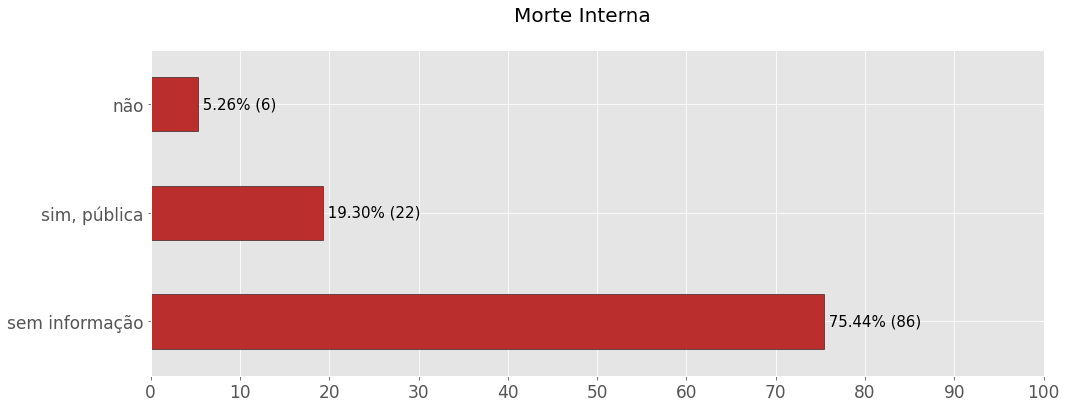

In [22]:
plot, fig = gera_grafico_geral("68 - Houve perícia?", planilha_filtrada_interna, "Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))

# loc_geral_variavel_68_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_houve_pericia_caso_interno.png"
# fig.savefig(loc_geral_variavel_68_1)

In [ ]:
plot, fig = gera_grafico_geral("68 - Houve perícia?", planilha_filtrada_externa, "Morte Externa", cor="#121fa1", x=20, y=10, eixo_y=(0, 110, 10), fonttamanho=17, fonttitulo=22, fontlabel=17)

loc_geral_variavel_68_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_houve_pericia_caso_externo.png"
fig.savefig(loc_geral_variavel_68_2)

sem informação    86
com informação    28
Name: var 68 vazio, dtype: int64


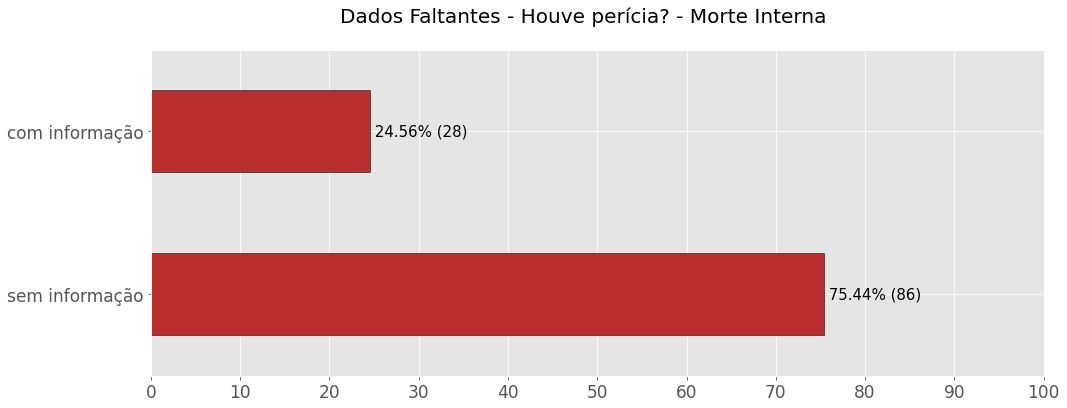

In [24]:
planilha_aux_interna = pd.DataFrame()
planilha_aux_interna["var 68 vazio"] = planilha_filtrada_interna["68 - Houve perícia?"].dropna()
planilha_aux_interna["var 68 vazio"] = np.where(planilha_aux_interna["var 68 vazio"] != "sem informação", "com informação", "sem informação")
print(planilha_aux_interna["var 68 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 68 vazio", planilha_aux_interna, "Dados Faltantes - Houve perícia? - Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))


## interno
# loc_geral_variavel_68_vazio_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_houve_pericia_vazio_interna.png"
# fig.savefig(loc_geral_variavel_68_vazio_1)

In [ ]:
planilha_aux_externa = pd.DataFrame()
planilha_aux_externa["var 68 vazio"] = planilha_filtrada_externa["68 - Houve perícia?"].dropna()
planilha_aux_externa["var 68 vazio"] = np.where(planilha_aux_externa["var 68 vazio"] != "sem informação", "com informação", "sem informação")
print(planilha_aux_externa["var 68 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 68 vazio", planilha_aux_externa, "Dados Faltantes - Houve perícia? - Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

# externo
loc_geral_variavel_68_vazio_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_houve_pericia_vazio_externa.png"
fig.savefig(loc_geral_variavel_68_vazio_2)

### 23 - Escolaridade

In [ ]:
# plot, fig = gera_grafico_geral("23 - Escolaridade", planilha_filtrada_interna, "Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))

In [ ]:
# plot, fig = gera_grafico_geral("23 - Escolaridade", planilha_filtrada_externa, "Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

com informação    67
sem informação    46
Name: var 23 vazio, dtype: int64


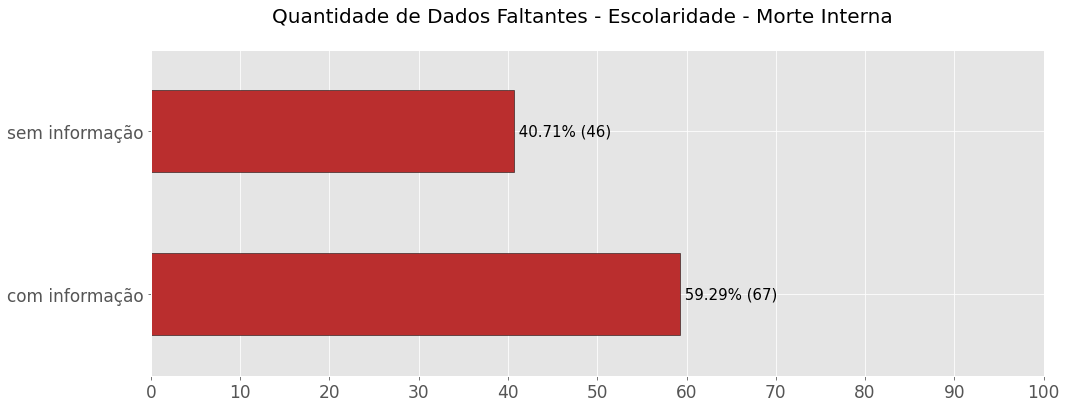

In [26]:
planilha_aux_interna = pd.DataFrame()
planilha_aux_interna["var 23 vazio"] = planilha_filtrada_interna["23 - Escolaridade"].dropna()
planilha_aux_interna["var 23 vazio"] = np.where(planilha_aux_interna["var 23 vazio"] != "sem informação", "com informação", "sem informação")
print(planilha_aux_interna["var 23 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 23 vazio", planilha_aux_interna, "Quantidade de Dados Faltantes - Escolaridade - Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))

# interno
# loc_geral_variavel_23_vazio_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_escolaridade_vazio_caso_interna.png"
# fig.savefig(loc_geral_variavel_23_vazio_1)

In [ ]:
planilha_aux_externa = pd.DataFrame()
planilha_aux_externa["var 23 vazio"] = planilha_filtrada_externa["23 - Escolaridade"].dropna()
planilha_aux_externa["var 23 vazio"] = np.where(planilha_aux_externa["var 23 vazio"] != "sem informação", "com informação", "sem informação")
print(planilha_aux_externa["var 23 vazio"].value_counts())

plot, fig = gera_grafico_geral("var 23 vazio", planilha_aux_externa, "Quantidade de Dados Faltantes - Escolaridade - Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

# externo
loc_geral_variavel_23_vazio_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_escolaridade_vazio_caso_externa.png"
fig.savefig(loc_geral_variavel_23_vazio_2)

### 22 - Situação de saúde

{'com informação': 30, 'sem informação': 84}
                 0
com informação  30
sem informação  84
                quantidade
com informação          30
sem informação          84
                quantidade  porcentagem
com informação          30    26.315789
sem informação          84    73.684211
                quantidade  porcentagem
com informação          30    26.315789
sem informação          84    73.684211


<ipython-input-104-fd175edd8da3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  planilha_filtrada_interna["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_filtrada_interna["22 - Situação de saúde com comorbidade (descreva na opção outros)"].astype(str).str.replace(",|\+",";", regex = True)
<ipython-input-104-fd175edd8da3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  planilha_filtrada_interna["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_

([<matplotlib.axis.XTick at 0x7f328e8ae6d0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

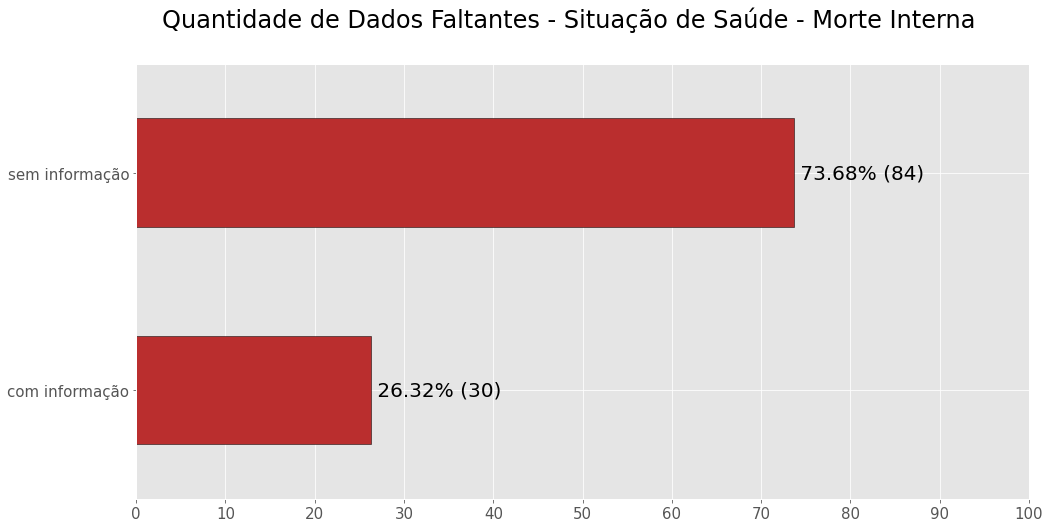

In [104]:
planilha_filtrada_interna["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_filtrada_interna["22 - Situação de saúde com comorbidade (descreva na opção outros)"].astype(str).str.replace(",|\+",";", regex = True)
planilha_filtrada_interna["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_filtrada_interna["22 - Situação de saúde com comorbidade (descreva na opção outros)"].astype(str).str.replace("(?:)\se\s",";", regex = True)
planilha_filtrada_interna["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_filtrada_interna["22 - Situação de saúde com comorbidade (descreva na opção outros)"].astype(str).str.replace("nan","", regex = True)

# pd.set_option('display.max_rows', None)
# print(planilha_filtrada["22 - Situação de saúde com comorbidade (descreva na opção outros)"])

arr_qtd_comorb = []
dict_grupos_comorb = {}
com_informacao = 0
sem_informacao = 0

for line in planilha_filtrada_interna["22 - Situação de saúde com comorbidade (descreva na opção outros)"]:
  if pd.isnull(line):
    arr_qtd_comorb.append(None)
    continue

  if ";" not in line:
    doc_sanitizado = strip_accents(line).strip().lower()
    if doc_sanitizado == "":
      arr_qtd_comorb.append(None)
      continue
    if doc_sanitizado == "sem informacao":
      arr_qtd_comorb.append(None)
      sem_informacao += 1
      if doc_sanitizado not in dict_grupos_comorb.keys():
        dict_grupos_comorb[doc_sanitizado] = 1
      else:
        dict_grupos_comorb[doc_sanitizado] += 1
      continue
    if doc_sanitizado == "nao":
      arr_qtd_comorb.append(0)
      com_informacao += 1
      continue
    arr_qtd_comorb.append(1)
    com_informacao += 1
    if doc_sanitizado not in dict_grupos_comorb.keys():
      dict_grupos_comorb[doc_sanitizado] = 1
    else:
      dict_grupos_comorb[doc_sanitizado] += 1
  else:
    com_informacao += 1
    docs = line.split(";")
    arr_qtd_comorb.append(len(docs))
    for doc in docs:
      doc_sanitizado = doc.strip().lower()
      if doc_sanitizado == "":
        continue
      if doc_sanitizado not in dict_grupos_comorb.keys():
        dict_grupos_comorb[doc_sanitizado] = 1
      else:
        dict_grupos_comorb[doc_sanitizado] += 1



  
dic_vazios = {}
dic_vazios["com informação"] = com_informacao
dic_vazios["sem informação"] = sem_informacao
print(dic_vazios)


df_vazios_interna = pd.DataFrame.from_dict(dic_vazios, orient='index')
print(df_vazios_interna)
df_vazios_interna.rename(columns = {0: "quantidade"}, inplace = True)
print(df_vazios_interna)
df_vazios_interna['porcentagem'] = df_vazios_interna['quantidade']/df_vazios_interna['quantidade'].sum()*100
print(df_vazios_interna)
# df_new_vazios_externa = df_vazios_externa.T
print(df_vazios_interna)

# # print(df_new_vazios_externa)
# # print(df_vazios_externa.T)
# df_new_vazios_externa = df_vazios_externa.T
# print(df_new_vazios_externa)
# df_new_vazios_externa['porcentagem'] = df_new_vazios_externa['quantidade']/df_new_vazios_externa['quantidade'].sum()*100
# print(df_new_vazios_externa)

plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle("Quantidade de Dados Faltantes - Situação de Saúde - Morte Interna", fontsize=24)
df_vazios_interna['porcentagem'].plot(ax=ax, kind='barh', color=['#ba2e2e'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_vazios_interna['quantidade'],df_vazios_interna['porcentagem']), fontsize=20)
plt.ylabel(None)
plt.xticks(range(0, 110, 10))
# loc_geral_variavel_situacao_saude_interna_vazio_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_situacao_saude_vazio_interna_2.png"
# fig.savefig(loc_geral_variavel_situacao_saude_interna_vazio_2)

vazio
vazio
vazio
vazio
vazio
vazio
vazio
vazio
{'com informação': 106, 'sem informação': 938}
{'sem informacao': 938, 'miocardia dilatada grave': 1, 'obesidade': 1, 'hiv positivo. informação sobre saúde nos autos: internado desde 10/04/2018 no hgr na uti devido ao quadro de abdome agudo perfurativo': 1, 'sendo submetido a laparotomia exploradora com ressecção': 1, 'rafia lesão em jejuno': 1, 'em 30/04/2018. recebeu alta hospitalar em 24/05/2018.': 1, 'a pessoa utilizava sonda': 1, 'dreno para urinar': 1, 'devido a uma grave fratura sofrida na região da bacia durante o trabalho': 1, 'dores pulmonares': 1, 'escarra sangue': 1, 'com deficit de apetite': 1, 'dores no estômago': 1, 'tuberculose': 8, 'diabetes': 6, 'hipertensão': 6, 'cardiopatia': 1, 'uso de cadeira de rodas em função de discopatia degenerativa (idoso)': 1, 'necessidade de tratamento em razão de pinos no pé + tratamento psiquiátrico': 1, 'em razão de "fortes dores de cabeça': 1, 'com surtos frequentes de epilepsia': 1, 'alé

<ipython-input-103-7f91e172c6ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  planilha_filtrada_externa["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_filtrada_externa["22 - Situação de saúde com comorbidade (descreva na opção outros)"].astype(str).str.replace(",",";", regex = True)
<ipython-input-103-7f91e172c6ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  planilha_filtrada_externa["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_fil

([<matplotlib.axis.XTick at 0x7f328e999b20>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

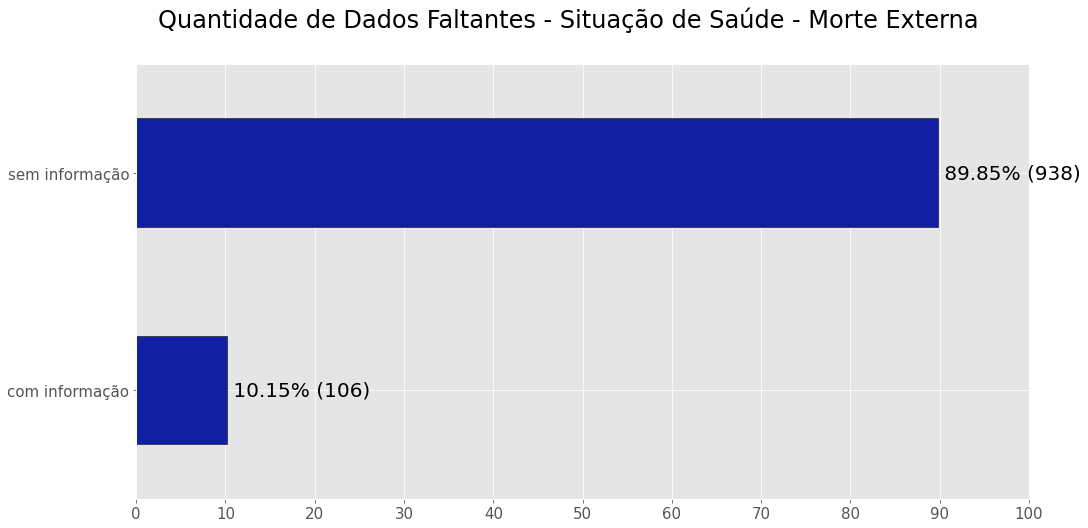

In [103]:
planilha_filtrada_externa["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_filtrada_externa["22 - Situação de saúde com comorbidade (descreva na opção outros)"].astype(str).str.replace(",",";", regex = True)
planilha_filtrada_externa["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_filtrada_externa["22 - Situação de saúde com comorbidade (descreva na opção outros)"].astype(str).str.replace("(?:)\se\s",";", regex = True)
planilha_filtrada_externa["22 - Situação de saúde com comorbidade (descreva na opção outros)"] = planilha_filtrada_externa["22 - Situação de saúde com comorbidade (descreva na opção outros)"].astype(str).str.replace("nan","", regex = True)
# pd.set_option('display.max_rows', None)
# print(planilha_filtrada["22 - Situação de saúde com comorbidade (descreva na opção outros)"])

# pd.set_option("max_rows", None)
# print(planilha_filtrada_externa["22 - Situação de saúde com comorbidade (descreva na opção outros)"])

arr_qtd_comorb = []
dict_grupos_comorb = {}
com_informacao = 0
sem_informacao = 0

for line in planilha_filtrada_externa["22 - Situação de saúde com comorbidade (descreva na opção outros)"]:
  if pd.isnull(line):
    arr_qtd_comorb.append(None)
    print("vazio")
    continue

  if ";" not in line:
    doc_sanitizado = strip_accents(line).strip().lower()
    if doc_sanitizado == "":
      arr_qtd_comorb.append(None)
      print("vazio")
      continue
    if doc_sanitizado == "sem informacao":
      arr_qtd_comorb.append(None)
      sem_informacao += 1
      if doc_sanitizado not in dict_grupos_comorb.keys():
        dict_grupos_comorb[doc_sanitizado] = 1
      else:
        dict_grupos_comorb[doc_sanitizado] += 1
      continue
    if doc_sanitizado == "nao":
      arr_qtd_comorb.append(0)
      com_informacao += 1
      continue
    arr_qtd_comorb.append(1)
    if doc_sanitizado not in dict_grupos_comorb.keys():
      dict_grupos_comorb[doc_sanitizado] = 1
      com_informacao += 1
    else:
      dict_grupos_comorb[doc_sanitizado] += 1
      com_informacao += 1
  else:
    docs = line.split(";")
    arr_qtd_comorb.append(len(docs))
    com_informacao += 1
    for doc in docs:
      doc_sanitizado = doc.strip().lower()
      if doc_sanitizado == "":
        continue
      if doc_sanitizado not in dict_grupos_comorb.keys():
        dict_grupos_comorb[doc_sanitizado] = 1
      else:
        dict_grupos_comorb[doc_sanitizado] += 1
        



  
dic_vazios = {}
dic_vazios["com informação"] = com_informacao
dic_vazios["sem informação"] = sem_informacao
print(dic_vazios)

print(dict_grupos_comorb)
df_vazios_externa = pd.DataFrame.from_dict(dic_vazios, orient='index')
print(df_vazios_externa)
df_vazios_externa.rename(columns = {0: "quantidade"}, inplace = True)
print(df_vazios_externa)
df_vazios_externa['porcentagem'] = df_vazios_externa['quantidade']/df_vazios_externa['quantidade'].sum()*100
print(df_vazios_externa)
# df_new_vazios_externa = df_vazios_externa.T
# print(df_vazios_externa)

# # print(df_new_vazios_externa)
# # print(df_vazios_externa.T)
# df_new_vazios_externa = df_vazios_externa.T
# print(df_new_vazios_externa)
# df_new_vazios_externa['porcentagem'] = df_new_vazios_externa['quantidade']/df_new_vazios_externa['quantidade'].sum()*100
# print(df_new_vazios_externa)

plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(16,8))
fig.suptitle("Quantidade de Dados Faltantes - Situação de Saúde - Morte Externa", fontsize=24)
df_vazios_externa['porcentagem'].plot(ax=ax, kind='barh', color=['#121fa1'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_vazios_externa['quantidade'],df_vazios_externa['porcentagem']), fontsize=20)
plt.ylabel(None)
plt.xticks(range(0, 110, 10))


# loc_geral_variavel_situacao_saude_externa_vazio_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_situacao_saude_vazio_externa_2.png"
# fig.savefig(loc_geral_variavel_situacao_saude_externa_vazio_2)

### 14 - Registro do nome completo, quando houver. (Quando não houver colocar "SI")

In [ ]:
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_interna['14 - Registro do nome completo, quando houver. (Quando não houver colocar "SI")']:
  if pd.isnull(j) or j.lower() == "nsa":
    continue
  
  if strip_accents(j).lower().strip() == "si" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Registro do nome completo - Morte Externa", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#ba2e2e'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))

loc_geral_variavel_14_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_registro_nome_completo_vazio_caso_interna_2.png"
fig.savefig(loc_geral_variavel_14_1)

In [ ]:
planilha_filtrada_externa.at[3020, '14 - Registro do nome completo, quando houver. (Quando não houver colocar "SI")'] = None
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_externa['14 - Registro do nome completo, quando houver. (Quando não houver colocar "SI")']:
  if pd.isnull(j) or j.lower() == "nsa":
    continue
  
  if strip_accents(j).lower().strip() == "si" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Registro do nome completo - Morte Externa", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#121fa1'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))

loc_geral_variavel_14_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_registro_nome_completo_vazio_caso_externa_2.png"
fig.savefig(loc_geral_variavel_14_2)

### 63 - Número do Inquérito Policial de investigação sobre a morte ( "SI" para "sem informação" ou "NSA" para não se aplica)

In [ ]:
nsa = 0
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_interna['63 - Número do Inquérito Policial de investigação sobre a morte ( "SI" para "sem informação" ou "NSA" para não se aplica)']:
  if pd.isnull(j) or j.lower() == "nsa":
    if str(j).lower() == "nsa": nsa += 1
    continue
  
  if strip_accents(j).lower().strip() == "si" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)
print(nsa)
df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Número Inquérito Policial - Morte Interna", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#ba2e2e'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))

loc_geral_variavel_63_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_num_inquerito_policial_vazio_caso_interna_2.png"
fig.savefig(loc_geral_variavel_63_1)

In [ ]:
nsa = 0
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_externa['63 - Número do Inquérito Policial de investigação sobre a morte ( "SI" para "sem informação" ou "NSA" para não se aplica)']:
  if pd.isnull(j) or j.lower() == "nsa":
    if str(j).lower() == "nsa": nsa += 1
    continue
  
  if strip_accents(j).lower().strip() == "si" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)
print(nsa)
df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Número Inquérito Policial - Morte Externa", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#121fa1'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))

loc_geral_variavel_63_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_num_inquerito_policial_vazio_caso_externa_2.png"
fig.savefig(loc_geral_variavel_63_2)

### 49 - Número da certidão de óbito

In [ ]:
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_interna['49 - Número da certidão de óbito']:
  if pd.isnull(j):
    continue
  
  if strip_accents(str(j)).lower().strip() == "nao ha" or strip_accents(j).lower().strip() == "si" or strip_accents(j).lower().strip() == "ilegivel" or j is None or strip_accents(j).lower().strip() == "nsa":
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Número Certidão de Óbito - Morte Interna", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#ba2e2e'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))

loc_geral_variavel_49_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_num_certidao_obito_vazio_caso_interna_2.png"
fig.savefig(loc_geral_variavel_49_1)

In [ ]:
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_externa['49 - Número da certidão de óbito']:
  if pd.isnull(j):
    continue

  if strip_accents(str(j)).lower().strip() == "nao ha" or strip_accents(str(j)).lower().strip() == "si" or strip_accents(str(j)).lower().strip() == "ilegivel" or j is None or strip_accents(str(j)).lower().strip() == "nsa":
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Número Certidão de Óbito - Morte Externa", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#121fa1'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))

loc_geral_variavel_49_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_num_certidao_obito_vazio_caso_externa_2.png"
fig.savefig(loc_geral_variavel_49_2)

### 42 - Quem informou a morte no processo judicial ou no inquérito policial ? (42 - codificada)

In [ ]:
plot, fig = gera_grafico_geral('42 - codificada', planilha_filtrada_interna, "Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_42_codificada_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_quem_informou_a_morte_interna_2.png"
fig.savefig(loc_geral_variavel_42_codificada_1)

In [ ]:
plot, fig = gera_grafico_geral('42 - codificada', planilha_filtrada_externa, "Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))

loc_geral_variavel_42_codificada_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_quem_informou_a_morte_externa_2.png"
fig.savefig(loc_geral_variavel_42_codificada_2)

In [ ]:
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_interna['42 - codificada']:
  if pd.isnull(j) or str(j).lower() == "nsa":
    continue
  
  if strip_accents(str(j)).lower().strip() == "sem informacoes" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Quem informou a morte codificada - Morte Interna", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#ba2e2e'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))

loc_geral_variavel_42_codificada_vazio_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_quem_informou_a_morte_codificada_vazio_interna_1.png"
fig.savefig(loc_geral_variavel_42_codificada_vazio_1)

In [ ]:
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_externa['42 - codificada']:
  if pd.isnull(j) or str(j).lower() == "nsa":
    continue
  
  if strip_accents(str(j)).lower().strip() == "sem informacoes" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Quem informou a morte codificada - Morte Externa", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#121fa1'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))

loc_geral_variavel_42_codificada_vazio_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_quem_informou_a_morte_codificada_vazio_externa_2.png"
fig.savefig(loc_geral_variavel_42_codificada_vazio_2)

### 24 - Profissão (24 - codificada)

In [ ]:
# plot, fig = gera_grafico_geral("24 - codificada", planilha_filtrada_interna, "Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_interna['24 - codificada']:
  if pd.isnull(j) or str(j).lower() == "nsa":
    continue
  
  if strip_accents(str(j)).lower().strip() == "sem informacoes" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Profissão codificada - Morte Interna", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#ba2e2e'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))

loc_geral_variavel_24_codificada_1 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_profissao_codificada_caso_interna_2.png"
fig.savefig(loc_geral_variavel_24_codificada_1)

In [ ]:
# plot, fig = gera_grafico_geral("24 - codificada", planilha_filtrada_externa, "Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_externa['24 - codificada']:
  if pd.isnull(j) or str(j).lower() == "nsa":
    continue
  
  if strip_accents(str(j)).lower().strip() == "sem informacoes" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Profissão codificada - Morte Externa", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#121fa1'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))


loc_geral_variavel_24_codificada_2 = "/content/drive/My Drive/codigos_colab/imagens_graficos/2/grafico_profissao_codificada_caso_externa_2.png"
fig.savefig(loc_geral_variavel_24_codificada_2)

## Raça

([<matplotlib.axis.XTick at 0x7f2a22bf6f70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

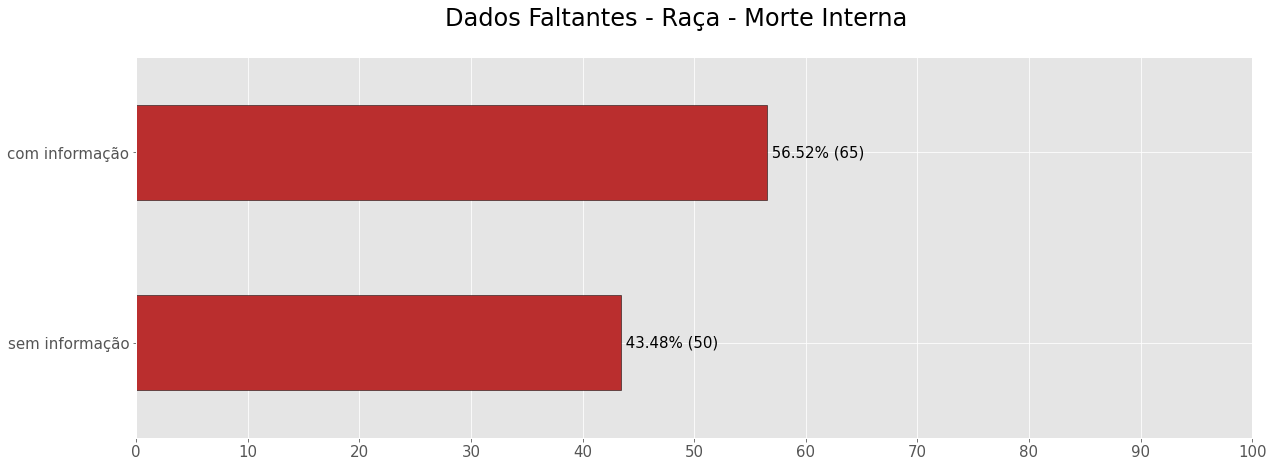

In [21]:
# plot, fig = gera_grafico_geral("24 - codificada", planilha_filtrada_interna, "Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_interna['18 - Raça']:
  if pd.isnull(j) or str(j).lower() == "nsa":
    continue
  
  if strip_accents(str(j)).lower().strip() == "sem informacao" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Raça - Morte Interna", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#ba2e2e'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))



([<matplotlib.axis.XTick at 0x7f2a2597f5b0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

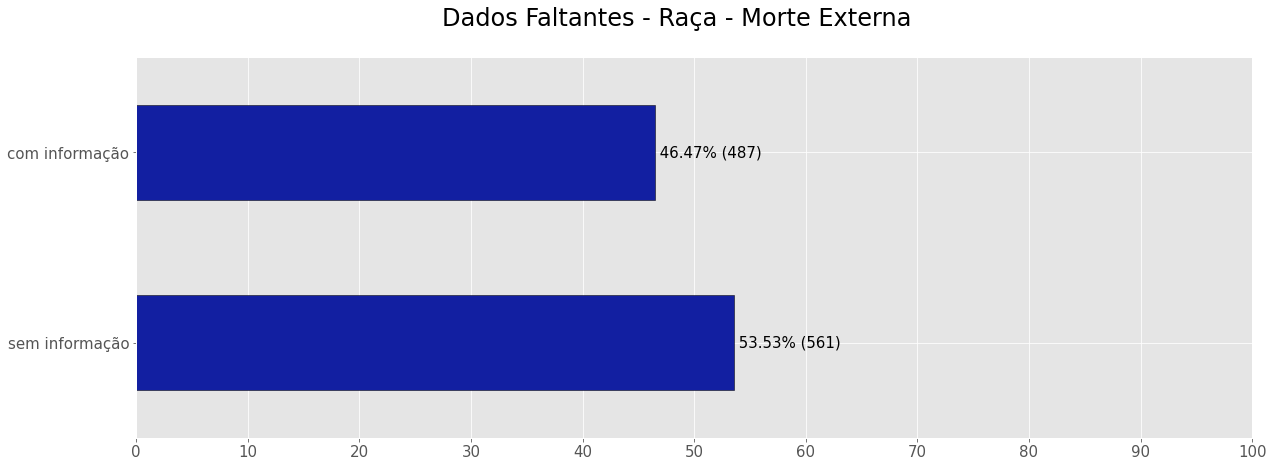

In [19]:
# plot, fig = gera_grafico_geral("24 - codificada", planilha_filtrada_externa, "Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_externa['18 - Raça']:
  if pd.isnull(j) or str(j).lower() == "nsa":
    continue
  
  if strip_accents(str(j)).lower().strip() == "sem informacao" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Raça - Morte Externa", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#121fa1'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))

## Template

## 75 - Identificação racial ao fim do processo

([<matplotlib.axis.XTick at 0x7f32930f3e80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

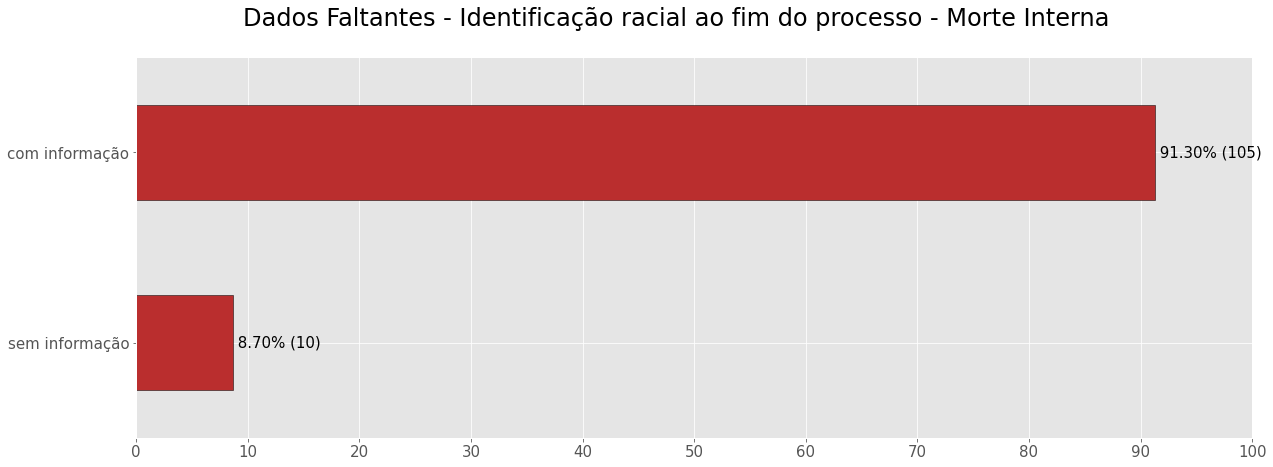

In [14]:
# plot, fig = gera_grafico_geral("24 - codificada", planilha_filtrada_interna, "Morte Interna", x=16, y=6, eixo_y=(0, 110, 10))
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_interna['75 - Identificação racial ao fim do processo']:
  if pd.isnull(j) or str(j).lower() == "nsa":
    continue
  
  if strip_accents(str(j)).lower().strip() == "sem informacao" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Identificação racial ao fim do processo - Morte Interna", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#ba2e2e'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))


([<matplotlib.axis.XTick at 0x7f3292c74040>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

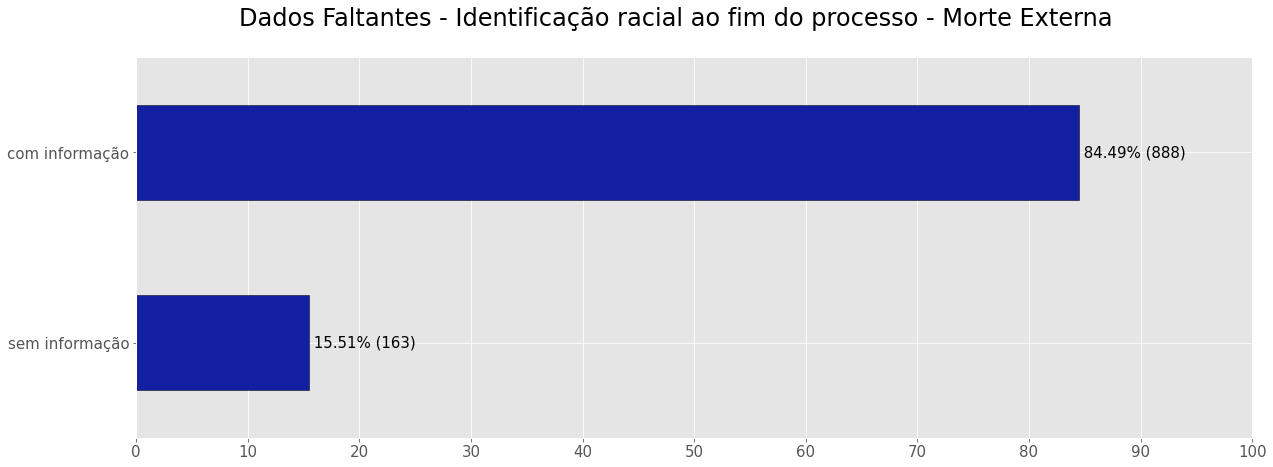

In [15]:
# plot, fig = gera_grafico_geral("24 - codificada", planilha_filtrada_externa, "Morte Externa", cor="#121fa1", x=16, y=6, eixo_y=(0, 110, 10))
dict_infos = {'sem informação': 0, 'com informação': 0}
for j in planilha_filtrada_externa['75 - Identificação racial ao fim do processo']:
  if pd.isnull(j) or str(j).lower() == "nsa":
    continue
  
  if strip_accents(str(j)).lower().strip() == "sem informacao" or j is None:
    dict_infos['sem informação'] += 1
  else:
    dict_infos['com informação'] += 1
# print(dict_infos)

df_dict_infos = pd.DataFrame.from_dict([dict_infos])
df_dict_infos.rename(index = {0: "quantidade"}, inplace = True)
# print(df_dict_infos)
df_dict_infos = df_dict_infos.T
# print(df_dict_infos)
df_dict_infos['porcentagem'] = df_dict_infos['quantidade']/df_dict_infos['quantidade'].sum()*100


plt.style.use(['ggplot'])
fig, ax = plt.subplots(figsize=(20,7))
fig.suptitle("Dados Faltantes - Identificação racial ao fim do processo - Morte Externa", fontsize=24)
df_dict_infos['porcentagem'].plot(ax=ax, kind='barh', color=['#121fa1'], fontsize=15, edgecolor="black")
ax.bar_label(ax.containers[0], labels=combine(df_dict_infos['quantidade'],df_dict_infos['porcentagem']), fontsize=15)
# plt.ylabel(None)
plt.xticks(range(0, 110, 10))

In [ ]:
## essa parte pega o template na pasta e usando o método DocxTemplate() salvamos o template dentro da variável documento

# arq_template = "/content/drive/My Drive/codigos_colab/template_tarefa_2.docx" # esse template está na pasta
# documento = DocxTemplate(arq_template)

In [ ]:

# ## aqui vc tem que colocar todos os gráficos

# # imagem = InlineImage(template onde a imagem deve ser inserida, imagem a ser inserida, tamanho da imagem a ser inserida)

# ## gráficos tópico 1
# grafico_geral_variavel_5 = InlineImage(documento, loc_geral_variavel_5, Cm(16))


# ## gráficos tópico 2
# grafico_variavel_15_interna = InlineImage(documento, loc_geral_variavel_15_1, Cm(16))
# grafico_variavel_15_externa = InlineImage(documento, loc_geral_variavel_15_2, Cm(16))
# grafico_variavel_27_interna = InlineImage(documento, loc_geral_variavel_27_1, Cm(16))
# grafico_variavel_27_externa = InlineImage(documento, loc_geral_variavel_27_2, Cm(16))
# grafico_renda_interna_2 = InlineImage(documento, loc_geral_variavel_renda_interna_2, Cm(16))
# grafico_renda_faixa_interna_2 = InlineImage(documento, loc_geral_variavel_renda_faixa_interna_2, Cm(16))
# grafico_renda_externa_2 = InlineImage(documento, loc_geral_variavel_renda_externa_2, Cm(16))
# grafico_renda_faixa_externa_2 = InlineImage(documento, loc_geral_variavel_renda_faixa_externa_2, Cm(16))
# grafico_renda_interna_sem_info = InlineImage(documento,loc_geral_variavel_renda_interna_sem_info, Cm(16))
# grafico_renda_externa_sem_info= InlineImage(documento,loc_geral_variavel_renda_externa_sem_info, Cm(16))
# grafico_variavel_30_interna = InlineImage(documento, loc_geral_variavel_30_1, Cm(16))
# grafico_variavel_30_externa = InlineImage(documento, loc_geral_variavel_30_2, Cm(16))
# grafico_variavel_31_interna = InlineImage(documento, loc_geral_variavel_31_1, Cm(16))
# grafico_variavel_31_externa = InlineImage(documento, loc_geral_variavel_31_2, Cm(16))
# grafico_variavel_48_interna = InlineImage(documento, loc_geral_variavel_48_1, Cm(16))
# grafico_variavel_48_externa = InlineImage(documento, loc_geral_variavel_48_2, Cm(16))
# grafico_variavel_61_interna = InlineImage(documento, loc_geral_variavel_61_1, Cm(16))
# grafico_variavel_61_externa = InlineImage(documento, loc_geral_variavel_61_2, Cm(16))
# grafico_variavel_68_interna = InlineImage(documento, loc_geral_variavel_68_1, Cm(16))
# grafico_variavel_68_externa = InlineImage(documento, loc_geral_variavel_68_2, Cm(17))
# grafico_variavel_30_vazio_interna = InlineImage(documento, loc_geral_variavel_30_vazio_1, Cm(16))
# grafico_variavel_30_vazio_externa = InlineImage(documento, loc_geral_variavel_30_vazio_2, Cm(16))
# grafico_variavel_27_vazio_interna = InlineImage(documento, loc_geral_variavel_27_vazio_1, Cm(16))
# grafico_variavel_27_vazio_externa = InlineImage(documento, loc_geral_variavel_27_vazio_2, Cm(16))
# grafico_variavel_31_vazio_interna = InlineImage(documento, loc_geral_variavel_31_vazio_1, Cm(16))
# grafico_variavel_31_vazio_externa = InlineImage(documento, loc_geral_variavel_31_vazio_2, Cm(16))
# grafico_variavel_61_vazio_interna = InlineImage(documento, loc_geral_variavel_61_vazio_1, Cm(16))
# grafico_variavel_61_vazio_externa = InlineImage(documento, loc_geral_variavel_61_vazio_2, Cm(16))
# grafico_variavel_68_vazio_interna = InlineImage(documento, loc_geral_variavel_68_vazio_1, Cm(16))
# grafico_variavel_68_vazio_externa = InlineImage(documento, loc_geral_variavel_68_vazio_2, Cm(16))
# grafico_variavel_23_vazio_interna_2 = InlineImage(documento, loc_geral_variavel_23_vazio_1, Cm(16))
# grafico_variavel_23_vazio_externa_2 = InlineImage(documento, loc_geral_variavel_23_vazio_2, Cm(16))
# grafico_variavel_situacao_saude_interna_vazio_2 = InlineImage(documento, loc_geral_variavel_situacao_saude_interna_vazio_2, Cm(16))
# grafico_variavel_situacao_saude_externa_vazio_2 = InlineImage(documento, loc_geral_variavel_situacao_saude_externa_vazio_2, Cm(16))
# grafico_variavel_14_interna = InlineImage(documento, loc_geral_variavel_14_1, Cm(16))
# grafico_variavel_14_externa = InlineImage(documento, loc_geral_variavel_14_2, Cm(16))
# grafico_variavel_63_interna = InlineImage(documento, loc_geral_variavel_63_1, Cm(16))
# grafico_variavel_63_externa = InlineImage(documento, loc_geral_variavel_63_2, Cm(16))
# grafico_variavel_49_interna = InlineImage(documento, loc_geral_variavel_49_1, Cm(16))
# grafico_variavel_49_externa = InlineImage(documento, loc_geral_variavel_49_2, Cm(16))
# grafico_variavel_24_codificada_interna = InlineImage(documento, loc_geral_variavel_24_codificada_1, Cm(16))
# grafico_variavel_24_codificada_externa = InlineImage(documento, loc_geral_variavel_24_codificada_2, Cm(16))
# grafico_variavel_42_codificada_interna = InlineImage(documento, loc_geral_variavel_42_codificada_1, Cm(16))
# grafico_variavel_42_codificada_externa = InlineImage(documento, loc_geral_variavel_42_codificada_2, Cm(16))
# grafico_variavel_42_codificada_interna_vazio = InlineImage(documento, loc_geral_variavel_42_codificada_vazio_1, Cm(16))
# grafico_variavel_42_codificada_externa_vazio = InlineImage(documento, loc_geral_variavel_42_codificada_vazio_2, Cm(16))



## gráficos tópico 3

# grafico_variavel_12_3 = InlineImage(documento, loc_geral_variavel_12_1_3, Cm(16))
# grafico_variavel_17_3 = InlineImage(documento, loc_geral_variavel_17_1_3, Cm(16))
# grafico_variavel_18_3 = InlineImage(documento, loc_geral_variavel_18_1_3, Cm(16))
# grafico_variavel_19_3 = InlineImage(documento, loc_geral_variavel_19_1_3, Cm(16))
# grafico_variavel_tempo_vida_3 = InlineImage(documento, loc_geral_variavel_tempo_vida_1_3, Cm(16))
# grafico_variavel_qtd_comorbidades_3 = InlineImage(documento, loc_geral_variavel_qtd_comorbidades_1_3, Cm(16))
# grafico_variavel_23_3 = InlineImage(documento, loc_geral_variavel_23_1_3, Cm(16))
# grafico_variavel_26_3 = InlineImage(documento, loc_geral_variavel_26_1_3, Cm(16))
# grafico_variavel_27_3 = InlineImage(documento, loc_geral_variavel_27_1_3, Cm(16))
# grafico_variavel_qtd_menor_12_3 = InlineImage(documento, loc_geral_variavel_qtd_menor_12_1_3, Cm(16))
# grafico_variavel_28_3 = InlineImage(documento, loc_geral_variavel_28_1_3, Cm(16))
# # grafico_variavel_renda_tratada_3 = InlineImage(documento, loc_geral_variavel_renda_tratada_1_3, Cm(16))
# grafico_variavel_30_3 = InlineImage(documento, loc_geral_variavel_30_1_3, Cm(16))
# grafico_variavel_31_3 = InlineImage(documento, loc_geral_variavel_31_1_3, Cm(16))
# grafico_variavel_32_3 = InlineImage(documento, loc_geral_variavel_32_1_3, Cm(16))
# grafico_variavel_37_3 = InlineImage(documento, loc_geral_variavel_37_1_3, Cm(16))
# # grafico_variavel_tempo_pena_sentenca_3 = InlineImage(documento, loc_geral_variavel_tempo_pena_sentenca_1_3, Cm(16))
# # grafico_variavel_tempo_total_pena_3 = InlineImage(documento, loc_geral_variavel_tempo_total_pena_1_3, Cm(16))


## gráficos tópico 4

# grafico_variavel_12_4 = InlineImage(documento, loc_geral_variavel_12_1_4, Cm(16))
# grafico_variavel_17_4 = InlineImage(documento, loc_geral_variavel_17_1_4, Cm(16))
# grafico_variavel_18_4 = InlineImage(documento, loc_geral_variavel_18_1_4, Cm(16))
# grafico_variavel_19_4 = InlineImage(documento, loc_geral_variavel_19_1_4, Cm(16))
# grafico_variavel_tempo_vida_4 = InlineImage(documento, loc_geral_variavel_tempo_vida_1_4, Cm(16))
# grafico_variavel_qtd_comorbidades_4 = InlineImage(documento, loc_geral_variavel_qtd_comorbidades_1_4, Cm(16))
# grafico_variavel_23_4 = InlineImage(documento, loc_geral_variavel_23_1_4, Cm(16))
# grafico_variavel_24_4 = InlineImage(documento, loc_geral_variavel_24_1_4, Cm(16))
# # grafico_variavel_25_4 = InlineImage(documento, loc_geral_variavel_25_1_4, Cm(16))
# grafico_variavel_26_4 = InlineImage(documento, loc_geral_variavel_26_1_4, Cm(16))
# grafico_variavel_27_4 = InlineImage(documento, loc_geral_variavel_27_1_4, Cm(16))
# grafico_variavel_qtd_menor_12_4 = InlineImage(documento, loc_geral_variavel_qtd_menor_12_1_4, Cm(16))
# grafico_variavel_28_4 = InlineImage(documento, loc_geral_variavel_28_1_4, Cm(16))
# # grafico_variavel_renda_tratada_4 = InlineImage(documento, loc_geral_variavel_renda_tratada_1_4, Cm(16))
# grafico_variavel_30_4 = InlineImage(documento, loc_geral_variavel_30_1_4, Cm(16))
# grafico_variavel_31_4 = InlineImage(documento, loc_geral_variavel_31_1_4, Cm(16))
# grafico_variavel_32_4 = InlineImage(documento, loc_geral_variavel_32_1_4, Cm(16))
# grafico_variavel_37_4 = InlineImage(documento, loc_geral_variavel_37_1_4, Cm(16))
# # grafico_variavel_tempo_pena_sentenca_4 = InlineImage(documento, loc_geral_variavel_tempo_pena_sentenca_1_4, Cm(16))
# # grafico_variavel_tempo_total_pena_4 = InlineImage(documento, loc_geral_variavel_tempo_total_pena_1_4, Cm(16))
# grafico_variavel_tempo_pena_ultima_prisao_4 = InlineImage(documento, loc_geral_variavel_tempo_pena_ultima_prisao_1_4, Cm(16))
# grafico_variavel_tempo_liberdade_morte_4 = InlineImage(documento, loc_geral_variavel_tempo_liberdade_morte_1_4, Cm(16))



## gráficos tópico 5

# grafico_variavel_53_1_5 = InlineImage(documento, loc_geral_variavel_53_1_5, Cm(16))
# grafico_variavel_53_2_5 = InlineImage(documento, loc_geral_variavel_53_2_5, Cm(16))
# grafico_variavel_qtd_comorbidades_1_5 = InlineImage(documento, loc_geral_variavel_qtd_comorbidades_1_5, Cm(16))
# grafico_variavel_qtd_comorbidades_2_5 = InlineImage(documento, loc_geral_variavel_qtd_comorbidades_2_5, Cm(16))


## gráficos tópico 6

# grafico_variavel_duracao_processo_1_6 = InlineImage(documento, loc_geral_variavel_duracao_processo_1_6, Cm(16))
# grafico_variavel_duracao_processo_2_6 = InlineImage(documento, loc_geral_variavel_duracao_processo_2_6, Cm(16))
# grafico_variavel_tempo_investigacao_morte_1_6 = InlineImage(documento, loc_geral_variavel_tempo_investigacao_morte_1_6, Cm(16))
# grafico_variavel_tempo_investigacao_morte_2_6 = InlineImage(documento, loc_geral_variavel_tempo_investigacao_morte_2_6, Cm(16))
# grafico_variavel_tempo_informar_morte_processo_1_6 = InlineImage(documento, loc_geral_variavel_tempo_informar_morte_processo_1_6, Cm(16))
# grafico_variavel_tempo_informar_morte_processo_2_6 = InlineImage(documento, loc_geral_variavel_tempo_informar_morte_processo_2_6, Cm(16))
# grafico_variavel_tempo_declaracao_extincao_punibilidade_1_6 = InlineImage(documento, loc_geral_variavel_tempo_declaracao_extincao_punibilidade_1_6, Cm(16))
# grafico_variavel_tempo_declaracao_extincao_punibilidade_2_6 = InlineImage(documento, loc_geral_variavel_tempo_declaracao_extincao_punibilidade_2_6, Cm(16))
# grafico_variavel_qtd_docs_1_6 = InlineImage(documento, loc_geral_variavel_qtd_docs_1_6, Cm(16))
# grafico_variavel_qtd_docs_2_6 = InlineImage(documento, loc_geral_variavel_qtd_docs_2_6, Cm(16))
# grafico_variavel_46_1_6 = InlineImage(documento, loc_geral_variavel_46_1_6, Cm(16))
# grafico_variavel_46_2_6 = InlineImage(documento, loc_geral_variavel_46_2_6, Cm(16))
# grafico_variavel_48_1_6 = InlineImage(documento, loc_geral_variavel_48_1_6, Cm(16))
# grafico_variavel_48_2_6 = InlineImage(documento, loc_geral_variavel_48_2_6, Cm(16))
# grafico_variavel_53_1_6 = InlineImage(documento, loc_geral_variavel_53_1_6, Cm(16))
# grafico_variavel_53_2_6 = InlineImage(documento, loc_geral_variavel_53_2_6, Cm(16))
# grafico_variavel_57_1_6 = InlineImage(documento, loc_geral_variavel_57_1_6, Cm(16))
# grafico_variavel_57_2_6 = InlineImage(documento, loc_geral_variavel_57_2_6, Cm(16))
# grafico_variavel_58_1_6 = InlineImage(documento, loc_geral_variavel_58_1_6, Cm(16))
# grafico_variavel_58_2_6 = InlineImage(documento, loc_geral_variavel_58_2_6, Cm(16))
# grafico_variavel_59_1_6 = InlineImage(documento, loc_geral_variavel_59_1_6, Cm(16))
# grafico_variavel_59_2_6 = InlineImage(documento, loc_geral_variavel_59_2_6, Cm(16))
# grafico_variavel_61_1_6 = InlineImage(documento, loc_geral_variavel_61_1_6, Cm(16))
# grafico_variavel_61_2_6 = InlineImage(documento, loc_geral_variavel_61_2_6, Cm(16))
# grafico_variavel_68_1_6 = InlineImage(documento, loc_geral_variavel_68_1_6, Cm(16))
# grafico_variavel_68_2_6 = InlineImage(documento, loc_geral_variavel_68_2_6, Cm(16))

In [ ]:
# contexto = {
#     'variavel_5_grafico_1': grafico_geral_variavel_5,
#     'variavel_15_grafico_1': grafico_variavel_15_interna,
#     'variavel_15_grafico_2': grafico_variavel_15_externa,
#     'variavel_27_grafico_1': grafico_variavel_27_interna,
#     'variavel_27_grafico_2': grafico_variavel_27_externa,
#     'variavel_renda_interna_grafico_2': grafico_renda_interna_2,
#     'variavel_renda_faixa_interna_grafico_2': grafico_renda_faixa_interna_2,
#     'variavel_renda_externa_grafico_2': grafico_renda_externa_2,
#     'variavel_renda_faixa_externa_grafico_2': grafico_renda_faixa_externa_2,
#     'grafico_renda_interna_sem_info': grafico_renda_interna_sem_info,
#     'grafico_renda_externa_sem_info': grafico_renda_externa_sem_info,
#     'variavel_30_grafico_1': grafico_variavel_30_interna,
#     'variavel_30_grafico_2': grafico_variavel_30_externa,
#     'variavel_31_grafico_1': grafico_variavel_31_interna,
#     'variavel_31_grafico_2': grafico_variavel_31_externa,
#     'variavel_48_grafico_1': grafico_variavel_48_interna,
#     'variavel_48_grafico_2': grafico_variavel_48_externa,
#     'variavel_61_grafico_1': grafico_variavel_61_interna,
#     'variavel_61_grafico_2': grafico_variavel_61_externa,
#     'variavel_68_grafico_1': grafico_variavel_68_interna,
#     'variavel_68_grafico_2': grafico_variavel_68_externa,
#     'grafico_variavel_30_vazio_interno': grafico_variavel_30_vazio_interna,
#     'grafico_variavel_30_vazio_externo': grafico_variavel_30_vazio_externa,
#     'variavel_27_vazios_interno': grafico_variavel_27_vazio_interna, ## filhos
#     'variavel_27_vazios_externo': grafico_variavel_27_vazio_externa, ## filhos
#     'variavel_31_vazios_interno': grafico_variavel_31_vazio_interna, ## 
#     'variavel_31_vazios_externo': grafico_variavel_31_vazio_externa, ## 
#     'variavel_61_vazios_interno': grafico_variavel_61_vazio_interna, ##
#     'variavel_61_vazios_externo': grafico_variavel_61_vazio_externa, 
#     'variavel_68_vazios_interno': grafico_variavel_68_vazio_interna, ##
#     'variavel_68_vazios_externo': grafico_variavel_68_vazio_externa,
#     'grafico_variavel_23_vazio_interna_2': grafico_variavel_23_vazio_interna_2,
#     'grafico_variavel_23_vazio_externa_2': grafico_variavel_23_vazio_externa_2,
#     'grafico_variavel_situacao_saude_interna_vazio_2': grafico_variavel_situacao_saude_interna_vazio_2,
#     'grafico_variavel_situacao_saude_externa_vazio_2': grafico_variavel_situacao_saude_externa_vazio_2,
#     'variavel_14_grafico_1': grafico_variavel_14_interna,
#     'variavel_14_grafico_2': grafico_variavel_14_externa,
#     'variavel_63_grafico_1': grafico_variavel_63_interna,
#     'variavel_63_grafico_2': grafico_variavel_63_externa,
#     'variavel_24_codificada_grafico_1': grafico_variavel_24_codificada_interna,
#     'variavel_24_codificada_grafico_2': grafico_variavel_24_codificada_externa,
#     'variavel_42_codificada_grafico_1': grafico_variavel_42_codificada_interna,
#     'variavel_42_codificada_grafico_2': grafico_variavel_42_codificada_externa,
#     'variavel_42_codificada_vazio_grafico_1': grafico_variavel_42_codificada_interna_vazio,
#     'variavel_42_codificada_vazio_grafico_2': grafico_variavel_42_codificada_externa_vazio,
#     'variavel_49_grafico_1': grafico_variavel_49_interna,
#     'variavel_49_grafico_2': grafico_variavel_49_externa

    # 'variavel_12_grafico_interna': grafico_variavel_12_3,
    # 'variavel_17_grafico_interna': grafico_variavel_17_3,
    # 'variavel_18_grafico_interna': grafico_variavel_18_3,
    # 'variavel_19_grafico_interna': grafico_variavel_19_3,
    # 'variavel_tempo_vida_grafico_interna': grafico_variavel_tempo_vida_3,
    # 'variavel_quantidade_comorbidades_grafico_interna': grafico_variavel_qtd_comorbidades_3,
    # 'variavel_23_grafico_interna': grafico_variavel_23_3,
    # 'variavel_26_grafico_interna': grafico_variavel_26_3,
    # 'variavel_27_grafico_interna': grafico_variavel_27_3,
    # 'variavel_menores_12_anos_grafico_interna': grafico_variavel_qtd_menor_12_3,
    # # 'variavel_renda_per_capita_grafico_interna': ,
    # 'variavel_28_grafico_interna': grafico_variavel_28_3,
    # # 'variavel_renda_grafico_interna': ,
    # 'variavel_30_grafico_interna': grafico_variavel_30_3,
    # 'variavel_31_grafico_interna': grafico_variavel_31_3,
    # 'variavel_32_grafico_interna': grafico_variavel_32_3,
    # 'variavel_37_grafico_interna': grafico_variavel_37_3,
    # # 'variavel_tempo_pena_sentenca_grafico_interna': ,
    # # 'variavel_tempo_total_pena_grafico_interna': 

    # 'variavel_12_grafico_4': grafico_variavel_12_4,
    # 'variavel_17_grafico_4': grafico_variavel_17_4,
    # 'variavel_18_grafico_4': grafico_variavel_18_4,
    # 'variavel_19_grafico_4': grafico_variavel_19_4,
    # 'variavel_tempo_vida_grafico_4': grafico_variavel_tempo_vida_4,
    # 'variavel_qtd_comorbidades_grafico_4': grafico_variavel_qtd_comorbidades_4,
    # 'variavel_23_grafico_4': grafico_variavel_23_4,
    # 'variavel_24_grafico_4': grafico_variavel_24_4,
    # # 'variavel_25_grafico_4': grafico_variavel_25_4,
    # 'variavel_26_grafico_4': grafico_variavel_26_4,
    # 'variavel_27_grafico_4': grafico_variavel_27_4,
    # 'variavel_qtd_menor_12_grafico_4': grafico_variavel_qtd_menor_12_4,
    # 'variavel_28_grafico_4': grafico_variavel_28_4,
    # # 'variavel_renda_tratada_grafico_4': grafico_variavel_renda_tratada_4,
    # 'variavel_30_grafico_4': grafico_variavel_30_4,
    # 'variavel_31_grafico_4': grafico_variavel_31_4,
    # 'variavel_32_grafico_4': grafico_variavel_32_4,
    # 'variavel_37_grafico_4': grafico_variavel_37_4,
    # # 'variavel_tempo_pena_sentenca_grafico_4': grafico_variavel_tempo_pena_sentenca_4,
    # # 'variavel_tempo_total_pena_grafico_4': grafico_variavel_tempo_total_pena_4,
    # 'variavel_tempo_pena_ultima_prisao_grafico_4': grafico_variavel_tempo_pena_ultima_prisao_4,
    # 'variavel_tempo_liberdade_morte_grafico_4': grafico_variavel_tempo_liberdade_morte_4,

    # 'variavel_53_grafico_1_5': grafico_variavel_53_1_5,
    # 'variavel_53_grafico_2_5': grafico_variavel_53_2_5,
    # 'variavel_quantidade_comorbidades_grafico_1_5': grafico_variavel_qtd_comorbidades_1_5,
    # 'variavel_quantidade_comorbidades_grafico_2_5': grafico_variavel_qtd_comorbidades_2_5,

    # 'variavel_duracao_processo_1_6': grafico_variavel_duracao_processo_1_6,
    # 'variavel_duracao_processo_2_6': grafico_variavel_duracao_processo_2_6,
    # 'variavel_tempo_investigacao_morte_1_6': grafico_variavel_tempo_investigacao_morte_1_6,
    # 'variavel_tempo_investigacao_morte_2_6': grafico_variavel_tempo_investigacao_morte_2_6,
    # 'variavel_tempo_informar_morte_processo_1_6': grafico_variavel_tempo_informar_morte_processo_1_6,
    # 'variavel_tempo_informar_morte_processo_2_6': grafico_variavel_tempo_informar_morte_processo_2_6,
    # 'variavel_declaracao_extincao_punibilidade_1_6': grafico_variavel_tempo_declaracao_extincao_punibilidade_1_6,
    # 'variavel_declaracao_extincao_punibilidade_2_6': grafico_variavel_tempo_declaracao_extincao_punibilidade_2_6,
    # 'variavel_qtd_documentos_1_6': grafico_variavel_qtd_docs_1_6,
    # 'variavel_qtd_documentos_2_6': grafico_variavel_qtd_docs_2_6,
    # 'variavel_46_grafico_1_6': grafico_variavel_46_1_6,
    # 'variavel_46_grafico_2_6': grafico_variavel_46_2_6,
    # 'variavel_48_grafico_1_6': grafico_variavel_48_1_6,
    # 'variavel_48_grafico_2_6': grafico_variavel_48_2_6,
    # 'variavel_53_grafico_1_6': grafico_variavel_53_1_6,
    # 'variavel_53_grafico_2_6': grafico_variavel_53_2_6,
    # 'variavel_57_grafico_1_6': grafico_variavel_57_1_6,
    # 'variavel_57_grafico_2_6': grafico_variavel_57_2_6,
    # 'variavel_58_grafico_1_6': grafico_variavel_58_1_6,
    # 'variavel_58_grafico_2_6': grafico_variavel_58_2_6,
    # 'variavel_59_grafico_1_6': grafico_variavel_59_1_6,
    # 'variavel_59_grafico_2_6': grafico_variavel_59_2_6,
    # 'variavel_61_grafico_1_6': grafico_variavel_61_1_6,
    # 'variavel_61_grafico_2_6': grafico_variavel_61_2_6,
    # 'variavel_68_grafico_1_6': grafico_variavel_68_1_6,
    # 'variavel_68_grafico_2_6': grafico_variavel_68_2_6

}

In [16]:
# # Geramos o documento, substituindo as variaveis do template pelos valores do contexto
# documento.render(contexto)

# # Salvamos o documento que era o template com os gráficos inseridos
# documento.save("/content/drive/My Drive/codigos_colab/relatorio_final.docx")

NameError: ignored